In [3]:
import os
import json
import re
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from skimage.io import imread, imsave
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import scipy.stats as stats

In [4]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [31]:
def gompertz(t, A, mu_m, lambda_):
    return A * np.exp(-np.exp(mu_m * np.e / A * (lambda_ - t) + 1))

### Making a dataframe from the results folders to handle the data

In [35]:
# params
path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'

In [32]:
df = pd.read_excel('Positions.xlsx')
df_out = df[df['Quality'] == 'Very good'].copy()
df_out = df_out.reset_index(drop=True)

# Initialize the columns as type 'object' to store arrays/lists
df_out.loc[:,["radius","area","max_av_gr"]] = np.nan
df_out['rad_dyn'] = pd.Series(dtype='object')
df_out['area_dyn'] = pd.Series(dtype='object')
df_out['av_gr_dyn'] = pd.Series(dtype='object')

df_out.loc[:,["gomp_params"]] = np.nan
df_out.loc[:,["t_m"]] = np.nan

# Assign an array to a cell in the DataFrame
# df_out.at[0, 'rad_dyn'] = np.array([0, 1, 2, 3, 4, 5])
# Similarly for 'area_dyn' if needed
# df_out.at[0, 'area_dyn'] = np.array([...])

# Display the head of the DataFrame to check the assignment
df_out.head()

Date   Machine  Position  Strain            DNA Chemical  Pad  \
0 2023-11-15  Ti scope         0  MC4100  pLPT20+pLPT41        -    1   
1 2023-11-15  Ti scope         1  MC4100  pLPT20+pLPT41        -    1   
2 2023-11-15  Ti scope         2  MC4100  pLPT20+pLPT41        -    1   
3 2023-11-15  Ti scope         3  MC4100  pLPT20+pLPT41        -    1   
4 2023-11-15  Ti scope         6  MC4100  pLPT20+pLPT41        -    1   

  Dilution   t_incub      t_im  ...  radj  wedge_adj  radius area  max_av_gr  \
0  10^(-5)  09:25:00  14:41:00  ...  30.0       30.0     NaN  NaN        NaN   
1  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   
2  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   
3  10^(-5)  09:25:00  14:41:00  ...  30.0       30.0     NaN  NaN        NaN   
4  10^(-5)  09:25:00  14:41:00  ...  50.0       30.0     NaN  NaN        NaN   

   rad_dyn  area_dyn  av_gr_dyn  gomp_params  t_m  
0      NaN       NaN        NaN          NaN  NaN  
1      NaN       NaN        NaN          NaN  NaN  
2      NaN       NaN        NaN          NaN  NaN  
3      NaN       NaN        NaN          NaN  NaN  
4      NaN       NaN        NaN          NaN  NaN  

[5 rows x 25 columns]

In [33]:
df_out.columns

Index(['Date', 'Machine', 'Position', 'Strain', 'DNA', 'Chemical', 'Pad',
       'Dilution', 't_incub', 't_im', 'Quality', 'exp length', 'Colonies',
       'Centers', 'Radius', 'radj', 'wedge_adj', 'radius', 'area', 'max_av_gr',
       'rad_dyn', 'area_dyn', 'av_gr_dyn', 'gomp_params', 't_m'],
      dtype='object')

#### Extract area and radius endpoints, as well as all dynamics

In [36]:
# extract area and radius from each position's results and store it in a dataframe
scopes = os.listdir(path)
for s in scopes:
    scope_dates = os.listdir(os.path.join(path,s))
    scope_dates.sort()
    for d in scope_dates:
        date = datetime.strptime(d, '%Y_%m_%d')
        data = df_out[(df_out.Date == date) & (df_out.Machine == s)]
        
        pos = data.Position.unique()
        path_results = os.path.join(path,s,d,'results')
        for p in pos:

            path_pos = os.path.join(path_results,f'pos{p}')
            area_path = os.path.join(path_pos, 'area.npy')
            radius_path = os.path.join(path_pos, 'radius.npy')

            ridx = df_out[(df_out.Date == date) & (df_out.Machine==s) & (df_out.Position == p)].index[0]

            # load area and radius
            radius = np.load(radius_path)  

            area = savgol_filter(np.load(area_path), 21, 3)
            area_diff = savgol_filter(np.diff(area), 21, 3)
            av_gr = savgol_filter(area_diff / area[1:], 21, 3)
                        
            # assigning
            df_out.loc[ridx, 'radius'] = radius[-1]
            df_out.loc[ridx, 'area'] = area[-1]
            df_out.loc[ridx, 'max_av_gr'] = np.nanmax(av_gr[np.isfinite(av_gr)])
            
            df_out.at[ridx, 'rad_dyn'] = radius
            df_out.at[ridx, 'area_dyn'] = area
            df_out.at[ridx, 'av_gr_dyn'] = av_gr

In [37]:
df_out.to_excel('out.xlsx')

In [38]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

### Plotting mean radius filtered by date, machine and dilution

In [165]:
# I can continue doing this with average growth rate, dynamical growth rate, etc
- rate of change of the radius (vfront) = dR/dt
- av growth rate = 1/A dA/dt

Histograms of two dilutions, overall view
group by strain as well analogy of cell dividing after reaching length or time? use the same for colonies on a pad

In [237]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

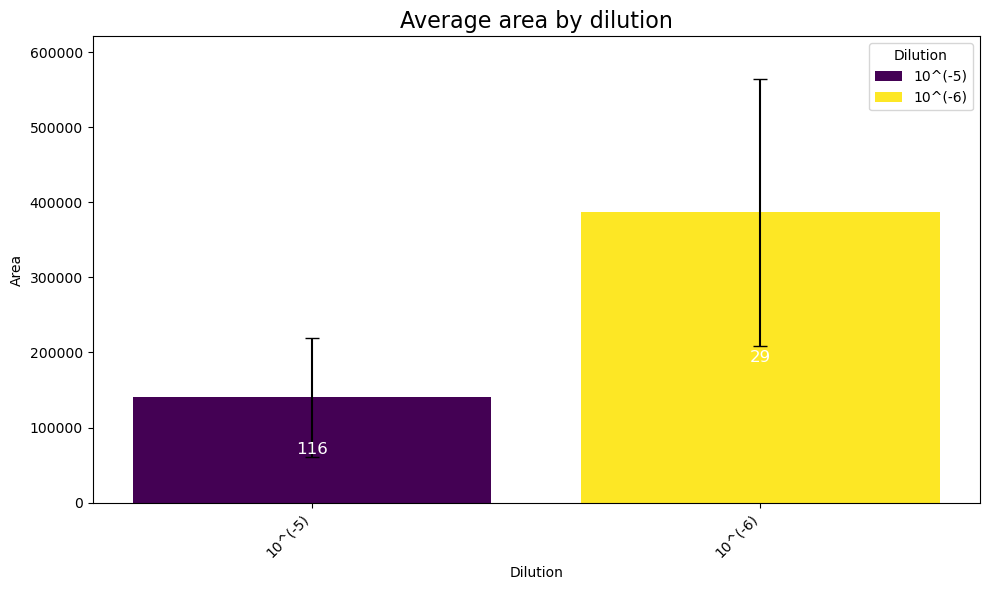

In [39]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'area' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'area': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Area Mean', 'Area Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_area = plot_data['Area Mean'] + plot_data['Area Std']
global_max = max_area.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
area_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Area Mean'], yerr=row['Area Std'], capsize=5, color=area_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Area Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average area by dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Av_area_dil_bar.png', dpi=300)

In [239]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

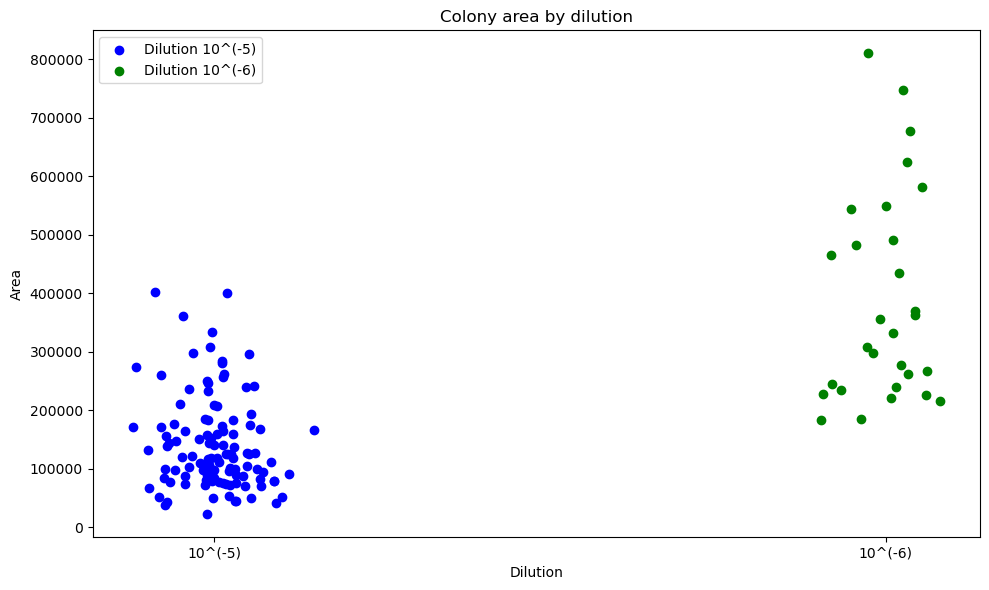

In [40]:
# Colors for each dilution
colors = ['blue', 'green']
dilutions = df['Dilution'].unique()

# Plot with distinct areas for each dilution
fig, ax = plt.subplots(figsize=(10, 6))

for i, dilution in enumerate(dilutions):
    # Create an offset for x positions to visually separate data
    x_positions = np.random.normal(i, 0.05, size=len(df[df['Dilution'] == dilution]))
    sub_data = df[df['Dilution'] == dilution]
    ax.scatter(x_positions, sub_data['area'], color=colors[i], label=f'Dilution {dilution}')

ax.set_title('Colony area by dilution')
ax.set_xlabel('Dilution')
ax.set_ylabel('Area')
ax.set_xticks(np.arange(len(dilutions)))
ax.set_xticklabels(dilutions)
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig('Area_dil_scatter.png', dpi=300)


Make histograms of the above

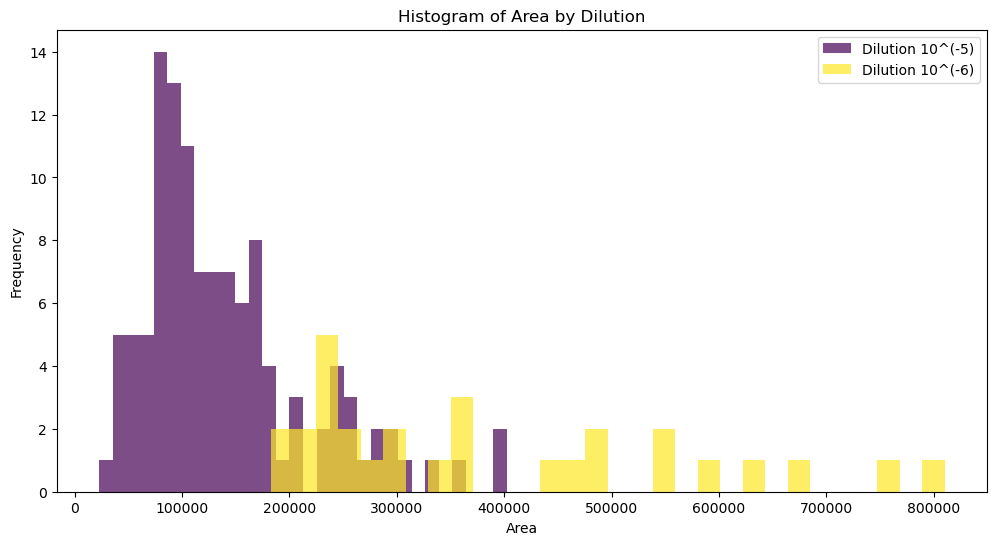

In [41]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

colors = plt.cm.viridis(np.linspace(0, 1, len(dilutions)))

# Plotting histograms
plt.figure(figsize=(12, 6))

# Histogram for the first dilution
plt.hist(data1, bins=30, alpha=0.7, label=f'Dilution {dilutions[0]}', color=colors[0])

# Histogram for the second dilution
plt.hist(data2, bins=30, alpha=0.7, label=f'Dilution {dilutions[1]}', color=colors[1])

plt.title('Histogram of Area by Dilution')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('His_Area_dil.png', dpi=300)
plt.show()



In [42]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# ANOVA test for more than two dilutions
if df['Dilution'].nunique() > 2:
    # Create groups for each dilution
    groups = [group['area'].dropna() for name, group in df.groupby('Dilution')]
    # Perform ANOVA
    f_val, p_val = stats.f_oneway(*groups)
    print("ANOVA test results: F =", f_val, ", P =", p_val)

# Two dilution groups
elif df['Dilution'].nunique() == 2:
    dilutions = df['Dilution'].unique()
    data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
    data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(data1, data2)
    print("T-test results: t =", t_stat, ", P =", p_val)

# Additional checks for assumptions (normality check for t-test)
if df['Dilution'].nunique() == 2:
    print("Normality Test for group 1:", stats.shapiro(data1))
    print("Normality Test for group 2:", stats.shapiro(data2))


T-test results: t = -11.189966338412743 , P = 2.8544126610780107e-21
Normality Test for group 1: ShapiroResult(statistic=0.8947407035466399, pvalue=1.5773641718912915e-07)
Normality Test for group 2: ShapiroResult(statistic=0.8958289136131105, pvalue=0.007795371192619198)


T-test Results
t-statistic = -11.1916567831005: This value is quite far from zero, indicating a significant difference between the means of the two groups.
The negative sign indicates that the mean of the first group is less than the mean of the second group.
P-value = 2.8255489504278984e-21: This extremely small p-value (far less than 0.05) strongly suggests that the differences in means 
between the two groups are statistically significant. In simpler terms, you can reject the null hypothesis that there is no difference 
between the means of the two groups, and conclude that the dilution levels do have a significant effect on the area.

Normality Test Results
Group 1:
Shapiro-Wilk Statistic = 0.8948546800667634
P-value = 1.597732944686496e-07: This p-value is less than 0.05, indicating that the data for this group does not follow a normal 
distribution.
Group 2:
Shapiro-Wilk Statistic = 0.8956199441658065
P-value = 0.007707217791473738: Similarly, this p-value is also less than 0.05, suggesting that the data for this group are not 
normally distributed either.


In [44]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Perform Mann-Whitney U test
u_stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')

print("Mann-Whitney U test results: U =", u_stat, ", P =", p_val)


Mann-Whitney U test results: U = 226.0 , P = 6.270685570240166e-13


In [ ]:
Interpretation:
Statistically Significant Difference: The very low p-value indicates strong evidence against the null hypothesis of the Mann-Whitney U test,
which states that there is a 50% chance that an observation from one group will be larger than an observation from the other group. 
Since the p-value is much smaller than 0.05, you can reject the null hypothesis.

Effect of Dilutions on Area: The results suggest that the dilution levels have a statistically significant effect on the area measurements. 
This means that the differences in area are not likely due to random chance, and there is a systematic difference in area between the two 
dilution groups being tested.
Practical Implications:
Decision Making: Based on this test, if you are in a situation where you are choosing between two dilution treatments (assuming these are the ones tested), there is statistically significant evidence to suggest that one of them leads to a different outcome in terms of area than the other.
Further Research: While the test indicates differences, it doesn't specify which group has the higher area. Further detailed analysis or additional data visualization could help in understanding the direction of this difference (e.g., examining the mean ranks or plotting the distributions). Moreover, examining why these differences occur could be beneficial in a practical setting.
Next Steps:
Examine the Data Further: You might want to look more closely at how the area values are distributed within each group to understand the nature of the differences — are they skewed, do they have outliers, etc.?
Consider Additional Factors: If there are more variables in your dataset, consider whether other factors might influence the relationship between dilution and area. Multivariable statistical methods or regression analysis could provide deeper insights.
This test provides a robust method for determining whether the differences observed in your study are statistically significant, helping guide further research and decision-making processes.

In [45]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

# Assuming there are exactly two dilution groups
dilutions = df['Dilution'].unique()
data1 = df[df['Dilution'] == dilutions[0]]['area'].dropna()
data2 = df[df['Dilution'] == dilutions[1]]['area'].dropna()

# Shapiro-Wilk Test for normality
shapiro_test1 = stats.shapiro(data1)
shapiro_test2 = stats.shapiro(data2)

print(f'Shapiro-Wilk Test for group 1: {shapiro_test1}')
print(f'Shapiro-Wilk Test for group 2: {shapiro_test2}')

# Kolmogorov-Smirnov Test assuming normal distribution
# First, get the normal distribution parameters (mean and std) from the data
ks_test1 = stats.kstest(data1, 'norm', args=(data1.mean(), data1.std()))
ks_test2 = stats.kstest(data2, 'norm', args=(data2.mean(), data2.std()))

print(f'Kolmogorov-Smirnov Test for group 1: {ks_test1}')
print(f'Kolmogorov-Smirnov Test for group 2: {ks_test2}')

# Anderson-Darling Test for normality
anderson_test1 = stats.anderson(data1, dist='norm')
anderson_test2 = stats.anderson(data2, dist='norm')

print(f'Anderson-Darling Test for group 1: {anderson_test1}')
print(f'Anderson-Darling Test for group 2: {anderson_test2}')


Shapiro-Wilk Test for group 1: ShapiroResult(statistic=0.8947407035466399, pvalue=1.5773641718912915e-07)
Shapiro-Wilk Test for group 2: ShapiroResult(statistic=0.8958289136131105, pvalue=0.007795371192619198)
Kolmogorov-Smirnov Test for group 1: KstestResult(statistic=0.14374374274510304, pvalue=0.01484901621528501, statistic_location=127287.8266516094, statistic_sign=1)
Kolmogorov-Smirnov Test for group 2: KstestResult(statistic=0.15723487667914354, pvalue=0.42657270176114903, statistic_location=370362.0039525698, statistic_sign=1)
Anderson-Darling Test for group 1: AndersonResult(statistic=3.821192395867172, critical_values=array([0.558, 0.635, 0.762, 0.889, 1.057]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=140475.98828670097, scale=79160.71534371605)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Anderson-Darling Test for group 2: AndersonResult(statistic=1.056733300387382, critical_values=ar

1. Shapiro-Wilk Test:
Group 1:
Statistic: 0.8948546800667634
P-value: 1.597732944686496e-07
Group 2:
Statistic: 0.8956199441658065
P-value: 0.007707217791473738
Both groups have a p-value less than 0.05, indicating strong evidence against the null hypothesis that the data is normally distributed. 
Thus, the data in both groups are not normally distributed.

2. Kolmogorov-Smirnov Test:
Group 1:
Statistic: 0.14390272693078227
P-value: 0.014689568872366082
Group 2:
Statistic: 0.15757983015701593
P-value: 0.4238651314229607
For Group 1, the p-value is below 0.05, suggesting that the data does not fit the normal distribution used as the model (with the same 
mean and standard deviation as the sample). For Group 2, the p-value is above 0.05, indicating insufficient evidence to reject the 
hypothesis that the data follows the modeled normal distribution; however, this does not confirm normality, especially considering the 
results from other tests.

3. Anderson-Darling Test:
Group 1:
Statistic: 3.8128734039981538
Critical Values: [0.558, 0.635, 0.762, 0.889, 1.057] for significance levels [15%, 10%, 5%, 2.5%, 1%]
Group 2:
Statistic: 1.0579504101067485
Critical Values: [0.52, 0.592, 0.71, 0.828, 0.985] for significance levels [15%, 10%, 5%, 2.5%, 1%]
For both groups, the test statistic exceeds the critical values at a 5% significance level, suggesting the data do not follow a 
normal distribution. This aligns with the Shapiro-Wilk test results and supports the non-normality of the data.

Conclusion:
All tests converge to the same conclusion that the data in both groups do not follow a normal distribution. This influences which 
types of statistical tests should be applied for further analysis, guiding you toward non-parametric methods for any comparative or 
correlative analysis involving these data sets.

- Make plots of 1/A dA/dt (peak average growth rate), compare bar graphs of that as well
- When the colony is smaller the peak growth rate goes up, when the colony is smaller it growths much more quicker.
- High dilutions low growth rates and low dilutions high growth
- Calculate 1/A dA/dt, smooth it out, fin the peak and use it as the value in the bar graph

Overall:
- They grow to bigger colonies in lower dilutions
- They grow faster in slower dilutions (high density)

In [49]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

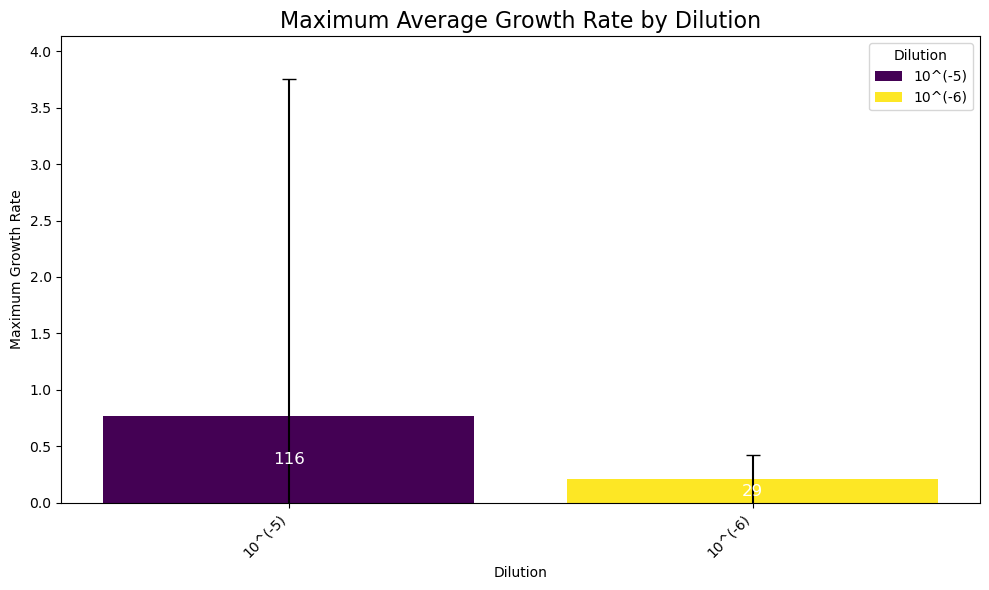

In [50]:
# Group the data by 'Dilution' only, and calculate mean, standard deviation for 'max_av_gr' and count colonies
plot_data = df.groupby(['Dilution']).agg({
    'max_av_gr': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Max Av GR Mean', 'Max Av GR Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_growth = plot_data['Max Av GR Mean'] + plot_data['Max Av GR Std']
global_max = max_growth.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
growth_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Max Av GR Mean'], yerr=row['Max Av GR Std'], capsize=5, color=growth_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Max Av GR Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Maximum Average Growth Rate by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Maximum Growth Rate')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

fig.savefig('Max_Av_GR_Dil_Bar.png', dpi=300)


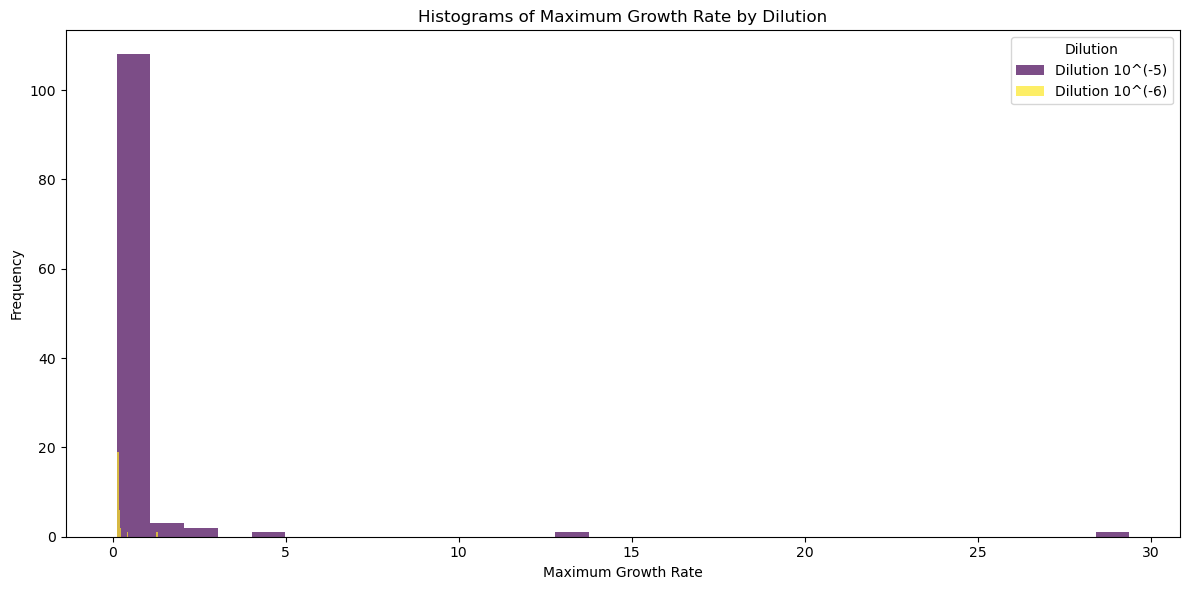

In [51]:
# Ensure that 'max_av_gr' contains only finite values
df = df[np.isfinite(df['max_av_gr'])]  # Filter to keep only rows where 'max_av_gr' is finite

# Retrieve unique dilutions to create histograms for each
unique_dilutions = df['Dilution'].unique()

# Set up the plot
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_dilutions)))

# Plot histograms for each dilution
for i, dilution in enumerate(unique_dilutions):
    data = df[df['Dilution'] == dilution]['max_av_gr']
    plt.hist(data, bins=30, alpha=0.7, label=f'Dilution {dilution}', color=colors[i])

plt.title('Histograms of Maximum Growth Rate by Dilution')
plt.xlabel('Maximum Growth Rate')
plt.ylabel('Frequency')
plt.legend(title="Dilution")
plt.savefig('His_Max_Av_GR_dil.png', dpi=300)
plt.tight_layout()
plt.show()


### Fit Gompertz

In [52]:
from scipy.optimize import curve_fit

In [53]:
def extract_array(s):
    numbers = re.findall(r"[-+]?\d*\.?\d+e[-+]?\d+|[-+]?\d*\.?\d+", s)
    return np.array([float(num) for num in numbers])

In [54]:
def gompertz(t, A, mu_m, lambda_):
    return A * np.exp(-np.exp(mu_m * np.e / A * (lambda_ - t) + 1))

In [55]:
df.loc[i, 'exp length']

216

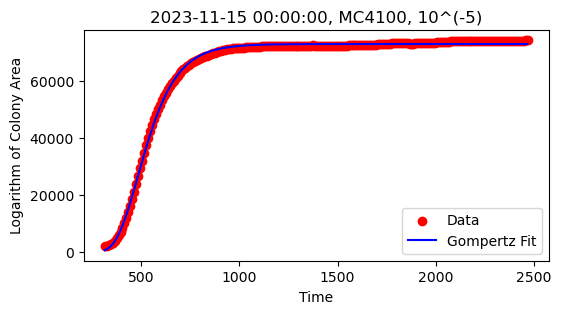

Fitted parameters [A, mu_m, lambda]: [72753.40167893   243.06196208   375.00396665], i: 0


/tmp/ipykernel_1909979/2255610959.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{"A": 72753.4, "mu_m": 243.06, "lambda": 375.0}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, 'gomp_params'] = json.dumps(pars_dict)


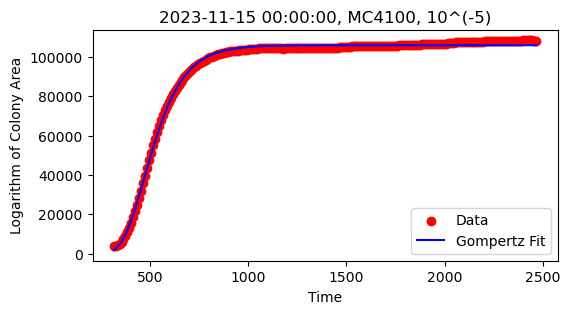

Fitted parameters [A, mu_m, lambda]: [105881.24478479    349.81823953    361.62244303], i: 1


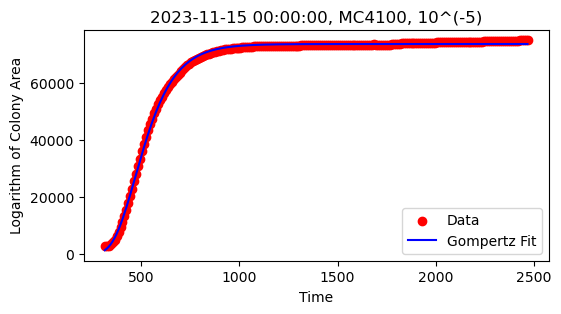

Fitted parameters [A, mu_m, lambda]: [73546.27357087   241.73245869   359.48985091], i: 2


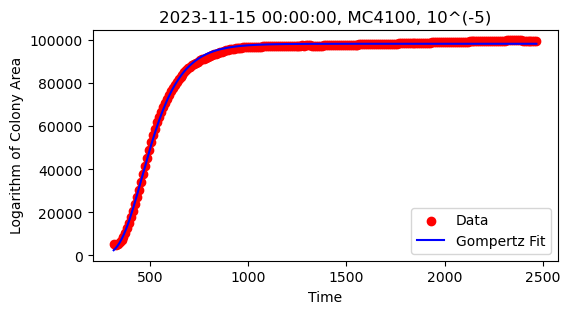

Fitted parameters [A, mu_m, lambda]: [98385.37774499   330.12098122   349.80015016], i: 3


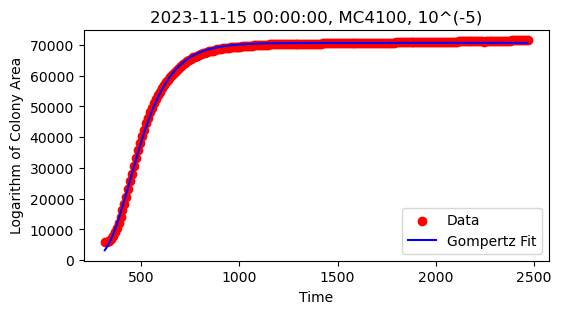

Fitted parameters [A, mu_m, lambda]: [70693.44280833   227.83210623   330.3063578 ], i: 4


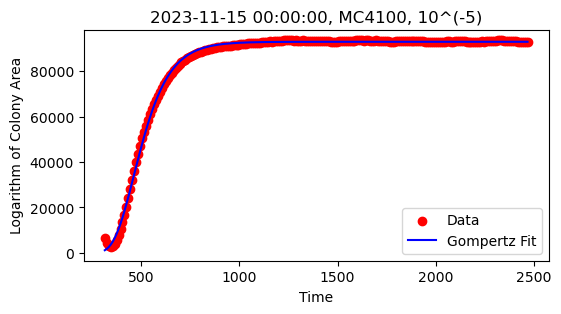

Fitted parameters [A, mu_m, lambda]: [92987.70108276   341.57595014   364.16149037], i: 5


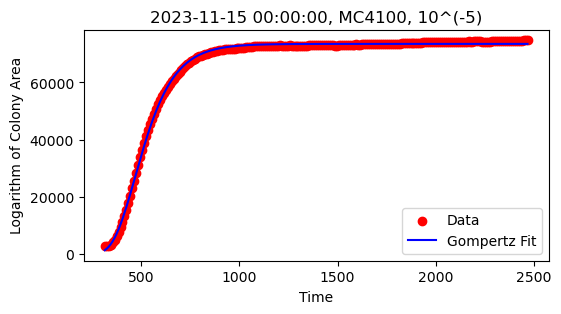

Fitted parameters [A, mu_m, lambda]: [73467.22899948   242.74092792   359.36742538], i: 6


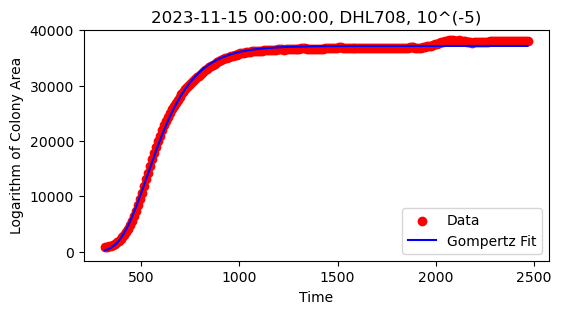

Fitted parameters [A, mu_m, lambda]: [37150.81750184   102.25916524   397.77846532], i: 7


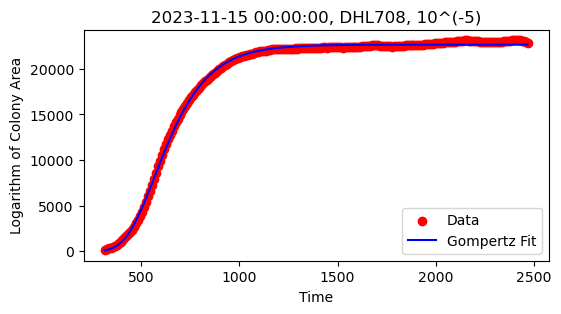

Fitted parameters [A, mu_m, lambda]: [22670.56693996    55.31711672   421.60689959], i: 8


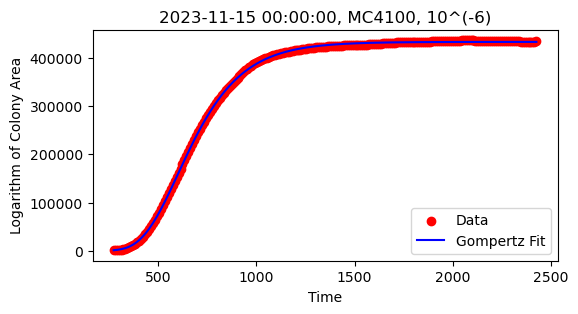

Fitted parameters [A, mu_m, lambda]: [4.33256340e+05 8.79560472e+02 4.21249994e+02], i: 9


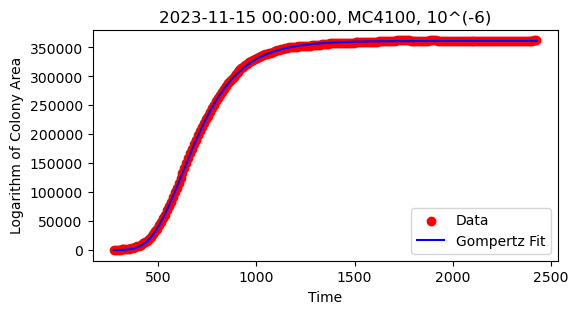

Fitted parameters [A, mu_m, lambda]: [361326.44812435    846.85076593    467.47500472], i: 10


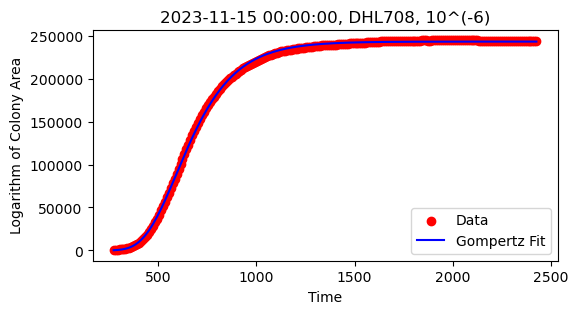

Fitted parameters [A, mu_m, lambda]: [243116.3238308     542.35725853    430.01883844], i: 11


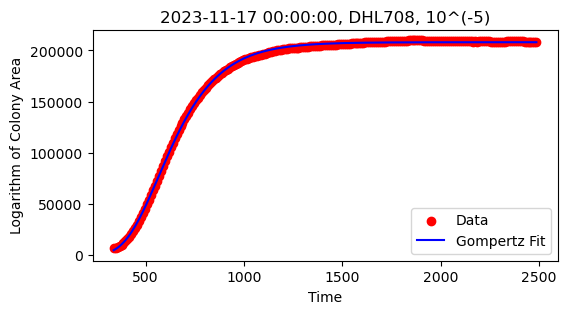

Fitted parameters [A, mu_m, lambda]: [207999.25473483    446.2622384     393.37341531], i: 12


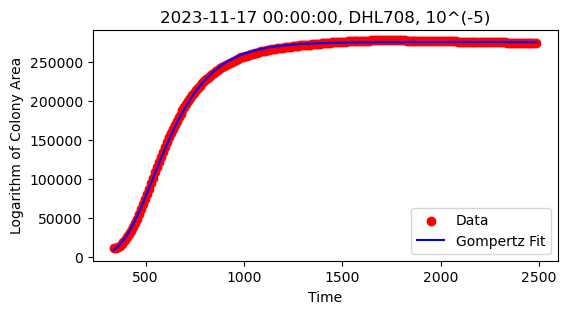

Fitted parameters [A, mu_m, lambda]: [274902.57595738    629.56310336    377.60286724], i: 13


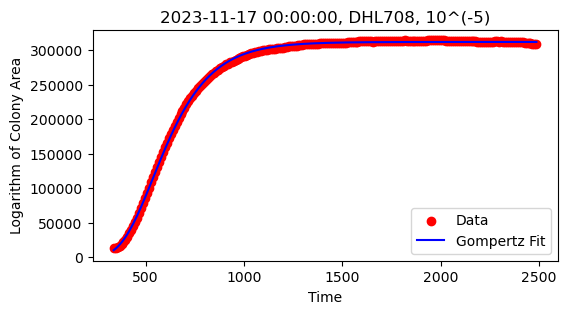

Fitted parameters [A, mu_m, lambda]: [312159.9384264     706.64245949    374.71067086], i: 14


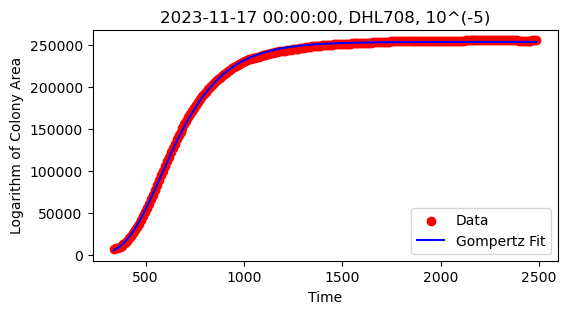

Fitted parameters [A, mu_m, lambda]: [254143.48928032    529.60074448    399.77998741], i: 15


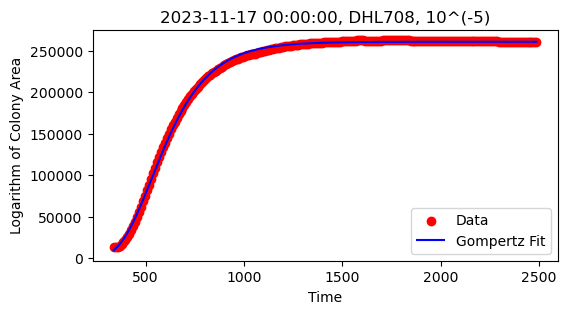

Fitted parameters [A, mu_m, lambda]: [260740.32346547    594.85170924    369.05478847], i: 16


/tmp/ipykernel_1909979/388095709.py:2: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-np.exp(mu_m * np.e / A * (lambda_ - t) + 1))


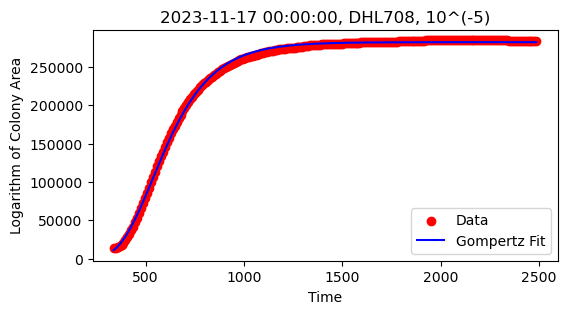

Fitted parameters [A, mu_m, lambda]: [282402.8456164     619.01436427    367.44220755], i: 17


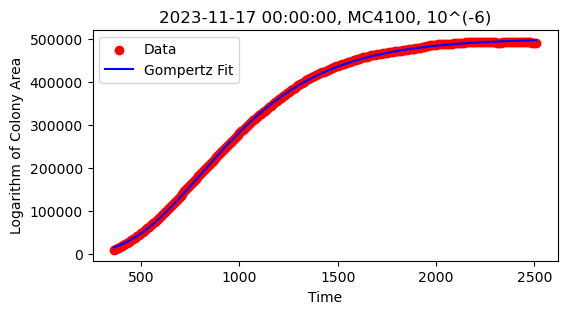

Fitted parameters [A, mu_m, lambda]: [5.00847260e+05 5.18636076e+02 4.45038344e+02], i: 18


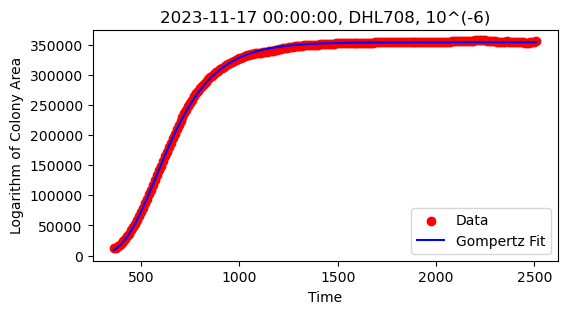

Fitted parameters [A, mu_m, lambda]: [354022.27892582    793.05417091    410.35182461], i: 19


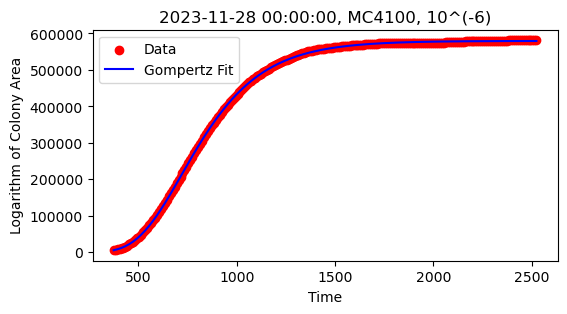

Fitted parameters [A, mu_m, lambda]: [5.79569277e+05 9.41612800e+02 4.93552726e+02], i: 20


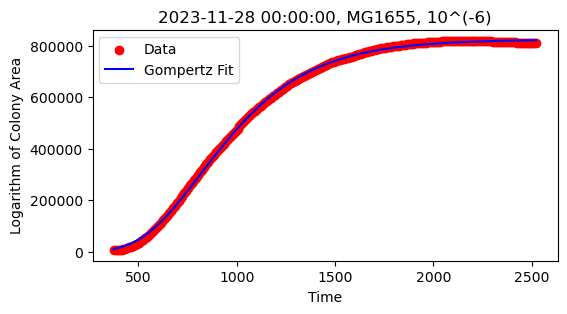

Fitted parameters [A, mu_m, lambda]: [8.24347493e+05 9.97429720e+02 5.13615980e+02], i: 21


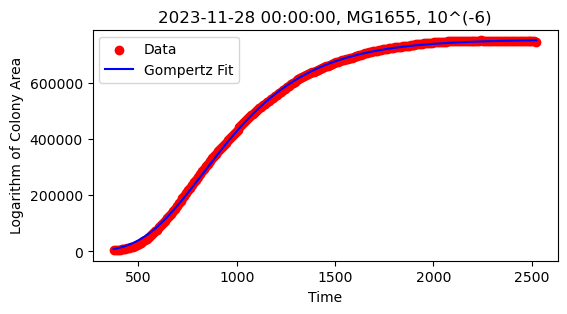

Fitted parameters [A, mu_m, lambda]: [7.55948414e+05 9.15661729e+02 5.23813172e+02], i: 22


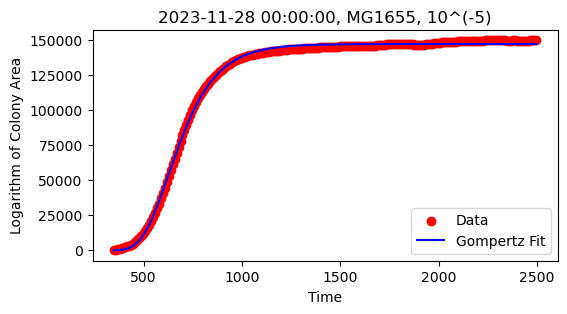

Fitted parameters [A, mu_m, lambda]: [147371.23829917    402.72746821    491.50957117], i: 23


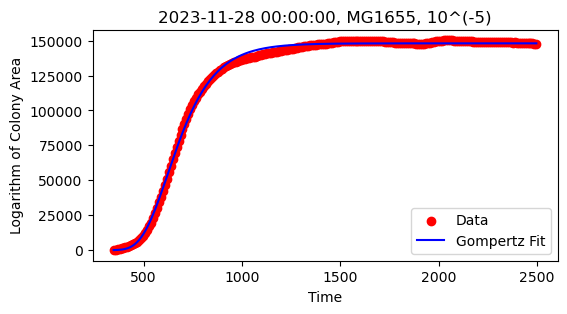

Fitted parameters [A, mu_m, lambda]: [148046.76184825    411.97318584    489.72314204], i: 24


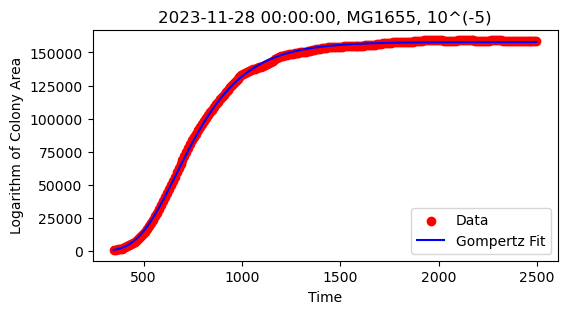

Fitted parameters [A, mu_m, lambda]: [157851.99707877    298.27146378    470.57415906], i: 25


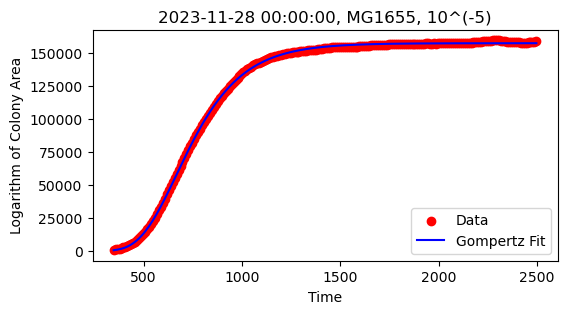

Fitted parameters [A, mu_m, lambda]: [157087.51083629    311.35901896    481.37035988], i: 26


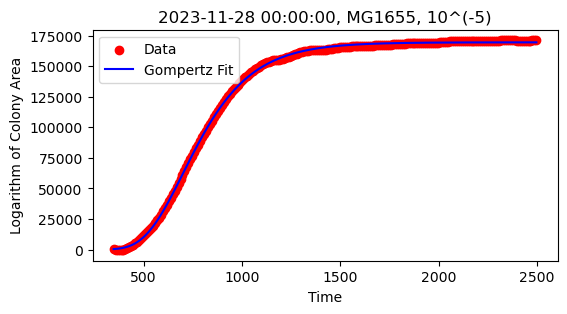

Fitted parameters [A, mu_m, lambda]: [169498.7264082     321.23398241    505.76441301], i: 27


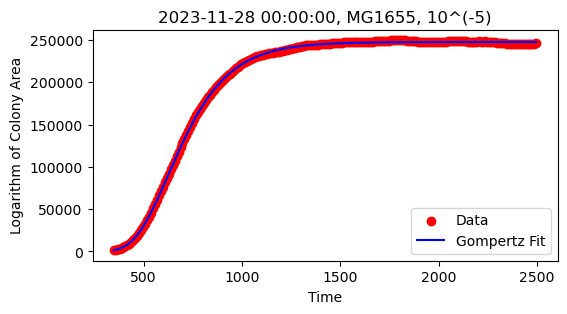

Fitted parameters [A, mu_m, lambda]: [247583.96361959    533.76350508    455.1150212 ], i: 28


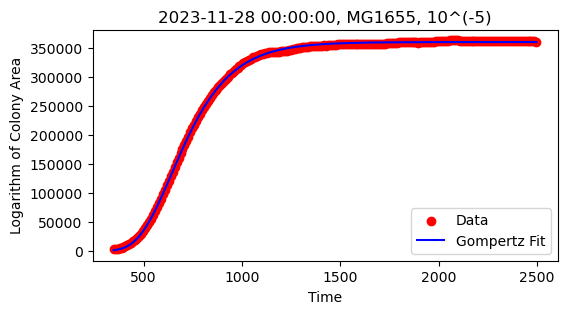

Fitted parameters [A, mu_m, lambda]: [359595.23351508    785.95714371    472.70348554], i: 29


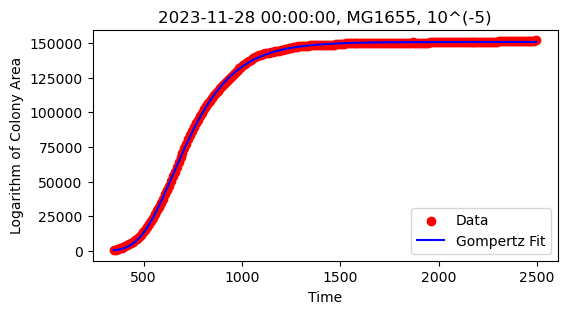

Fitted parameters [A, mu_m, lambda]: [150777.99206161    328.52669608    481.0791164 ], i: 30


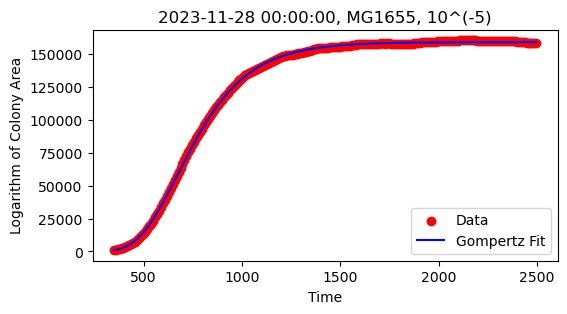

Fitted parameters [A, mu_m, lambda]: [158729.77434817    292.89240334    473.01714077], i: 31


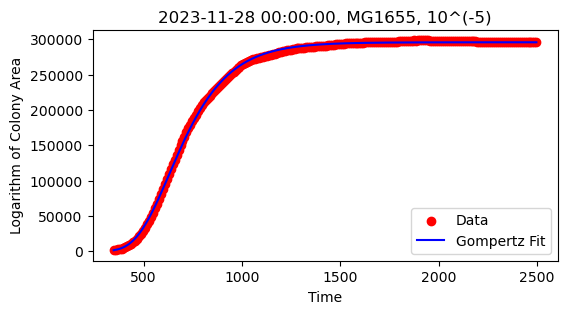

Fitted parameters [A, mu_m, lambda]: [295604.98282824    645.42072423    460.8311571 ], i: 32


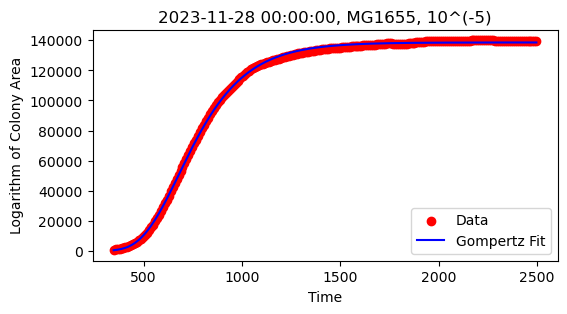

Fitted parameters [A, mu_m, lambda]: [138582.53823763    269.16215476    489.86087334], i: 33


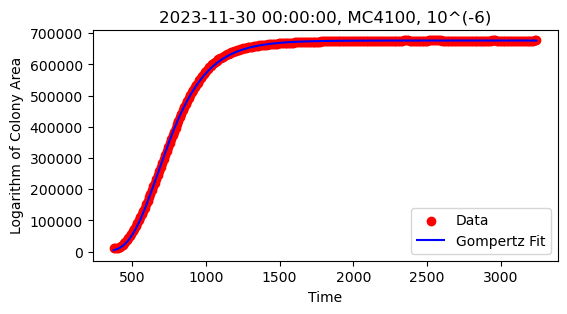

Fitted parameters [A, mu_m, lambda]: [6.76733580e+05 1.34811603e+03 4.85967587e+02], i: 34


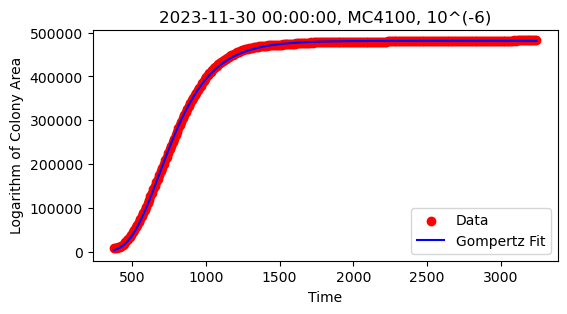

Fitted parameters [A, mu_m, lambda]: [481302.13478043    898.51956585    485.09784261], i: 35


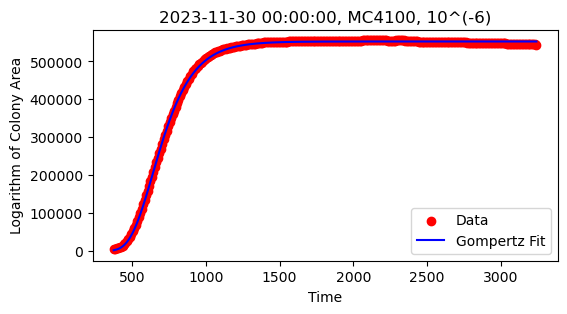

Fitted parameters [A, mu_m, lambda]: [5.52797428e+05 1.33500829e+03 4.85898994e+02], i: 36


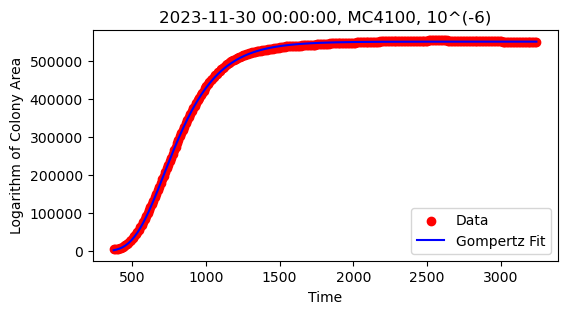

Fitted parameters [A, mu_m, lambda]: [5.51833916e+05 9.90279063e+02 5.10191561e+02], i: 37


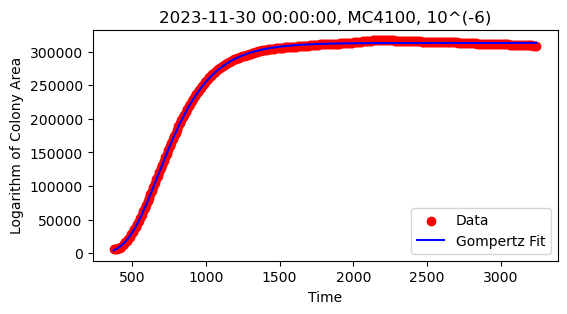

Fitted parameters [A, mu_m, lambda]: [313158.16302554    558.96415974    466.56509192], i: 38


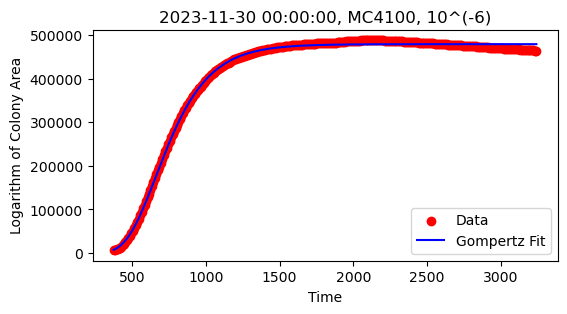

Fitted parameters [A, mu_m, lambda]: [4.79405219e+05 8.76908070e+02 4.59049719e+02], i: 39


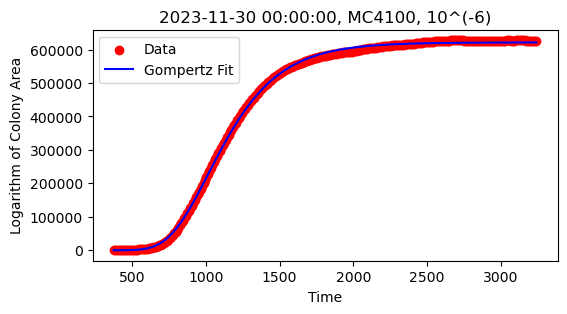

Fitted parameters [A, mu_m, lambda]: [621311.99079053    854.32398914    748.32643093], i: 40


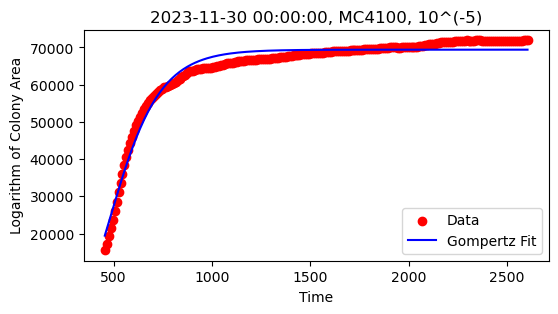

Fitted parameters [A, mu_m, lambda]: [69399.39240911   177.87055549   346.1089255 ], i: 41


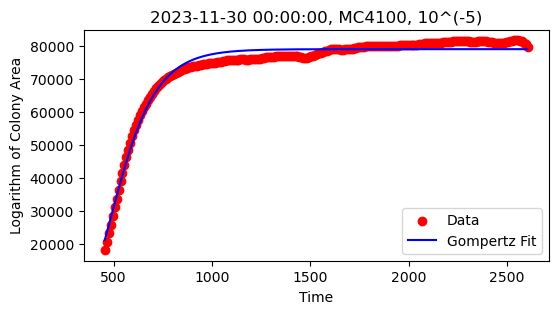

Fitted parameters [A, mu_m, lambda]: [79053.02286556   224.56682139   361.57351285], i: 42


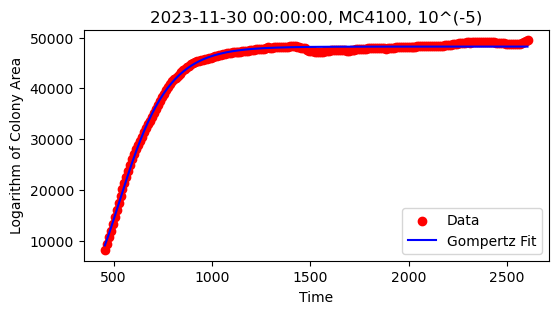

Fitted parameters [A, mu_m, lambda]: [48229.51572057   122.07888128   384.33565798], i: 43


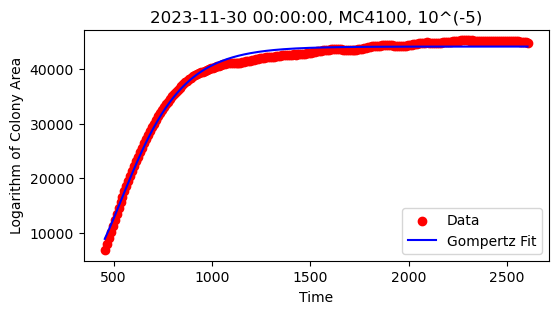

Fitted parameters [A, mu_m, lambda]: [44106.0550501     88.69150742   357.70492837], i: 44


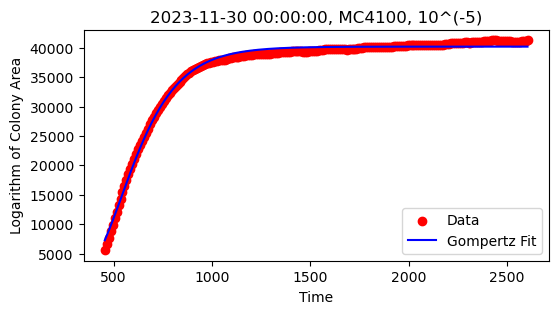

Fitted parameters [A, mu_m, lambda]: [40211.06237597    91.93216834   380.50304947], i: 45


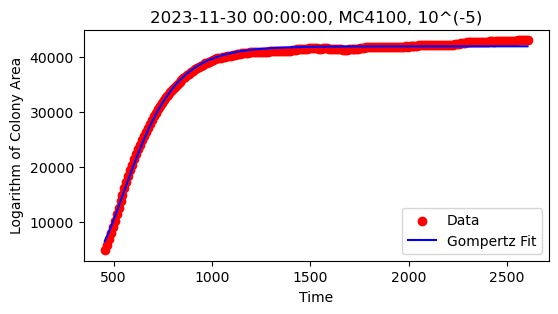

Fitted parameters [A, mu_m, lambda]: [41969.99653466    99.72858973   397.394323  ], i: 46


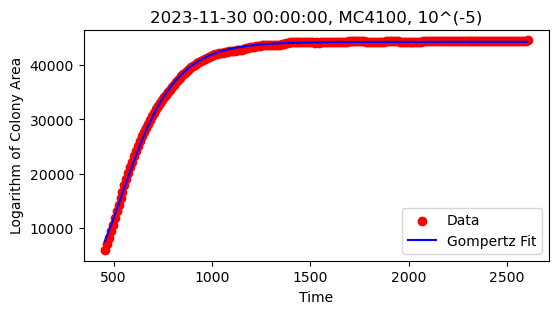

Fitted parameters [A, mu_m, lambda]: [44308.00980393   104.28859192   387.75976466], i: 47


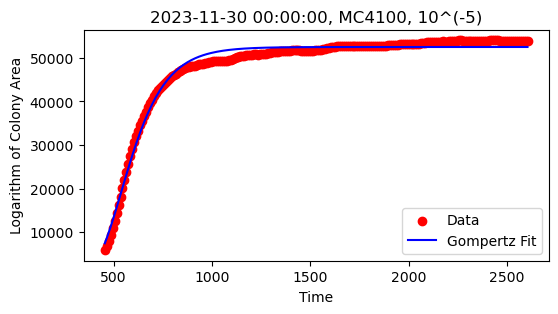

Fitted parameters [A, mu_m, lambda]: [52488.47677612   153.48240506   413.50085436], i: 48


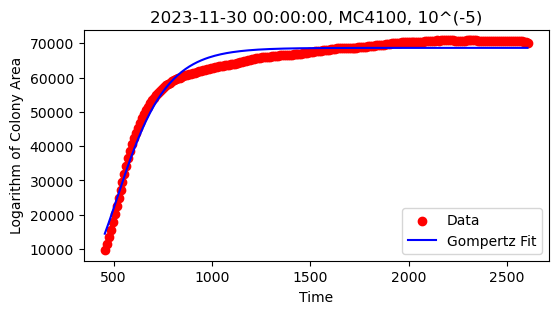

Fitted parameters [A, mu_m, lambda]: [68643.79946045   172.4811386    373.22154392], i: 49


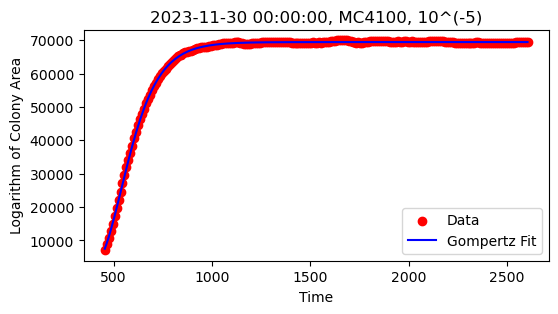

Fitted parameters [A, mu_m, lambda]: [69433.85048936   241.2536288    433.76753952], i: 50


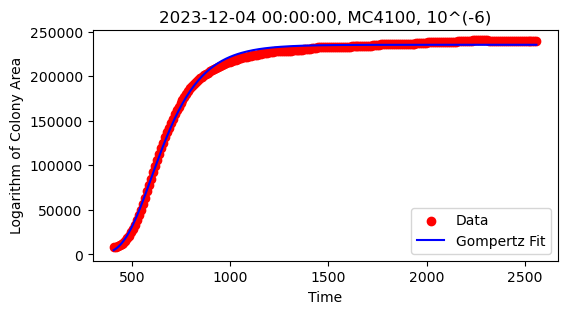

Fitted parameters [A, mu_m, lambda]: [235339.60807624    611.94020344    459.06629905], i: 51


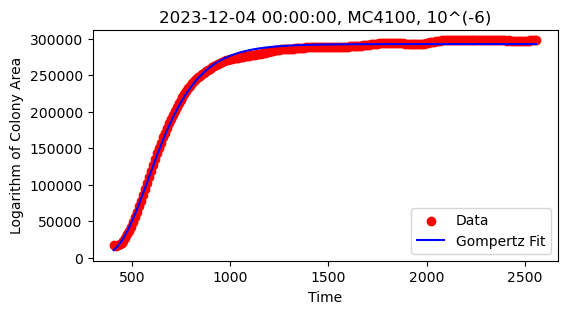

Fitted parameters [A, mu_m, lambda]: [292624.71423959    741.91980523    438.74750515], i: 52


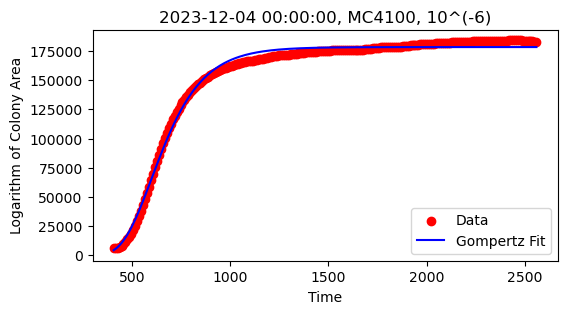

Fitted parameters [A, mu_m, lambda]: [178370.5342739     447.38794955    454.0574304 ], i: 53


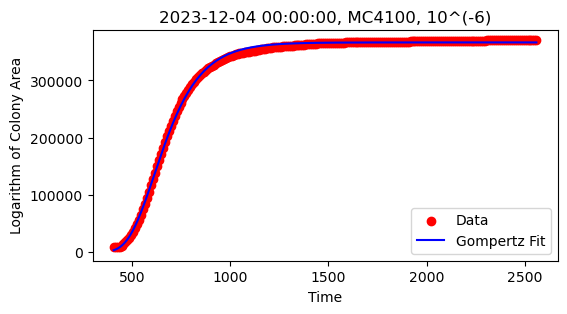

Fitted parameters [A, mu_m, lambda]: [366574.84542828   1021.05948389    482.12743893], i: 54


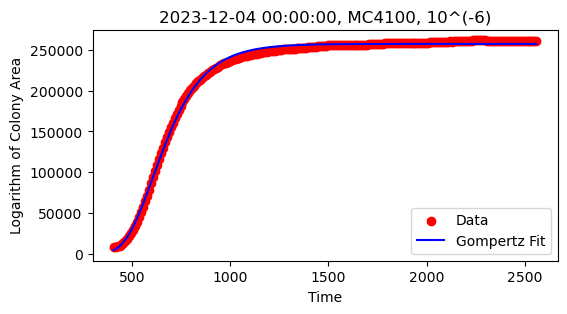

Fitted parameters [A, mu_m, lambda]: [257488.79905606    663.86037308    466.52450263], i: 55


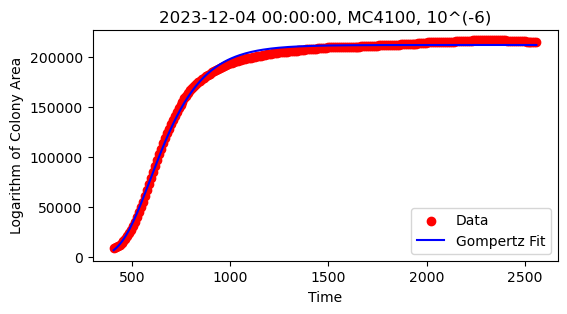

Fitted parameters [A, mu_m, lambda]: [211709.69790471    517.25925818    444.86330043], i: 56


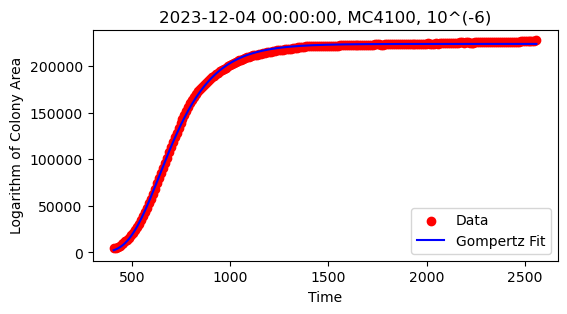

Fitted parameters [A, mu_m, lambda]: [223978.25232636    535.18658955    486.22844374], i: 57


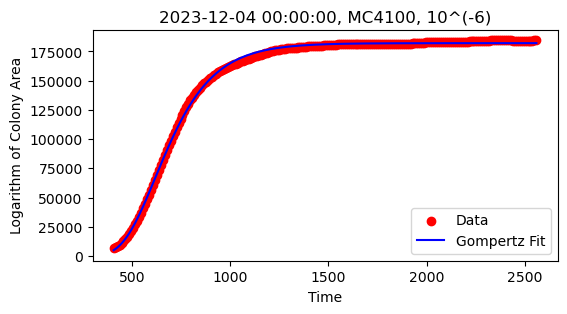

Fitted parameters [A, mu_m, lambda]: [182151.25115159    406.24738153    454.90900231], i: 58


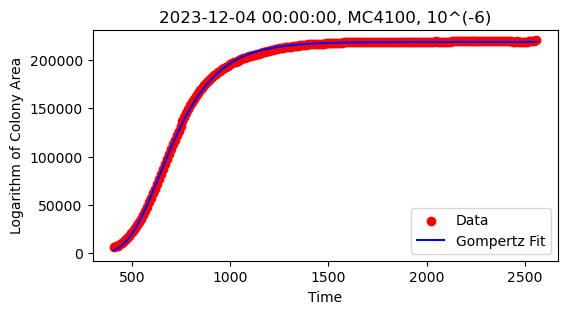

Fitted parameters [A, mu_m, lambda]: [218560.71805962    499.36335203    479.94145012], i: 59


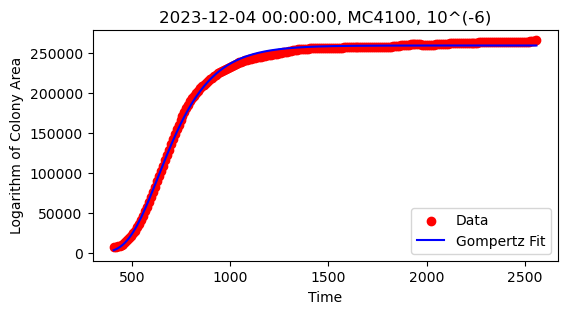

Fitted parameters [A, mu_m, lambda]: [259652.70187238    623.87502567    481.79134669], i: 60


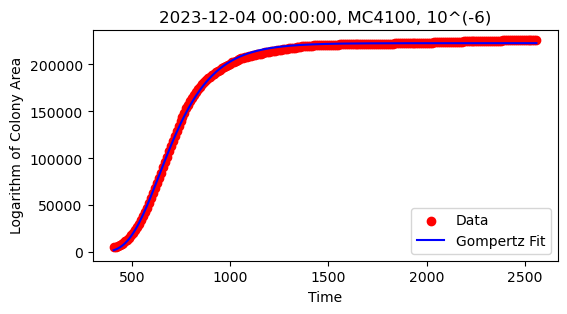

Fitted parameters [A, mu_m, lambda]: [222706.10169696    540.8768905     487.5726888 ], i: 61


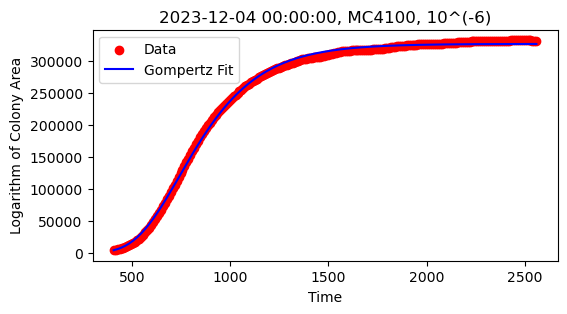

Fitted parameters [A, mu_m, lambda]: [326662.72342725    533.34403007    518.06980001], i: 62


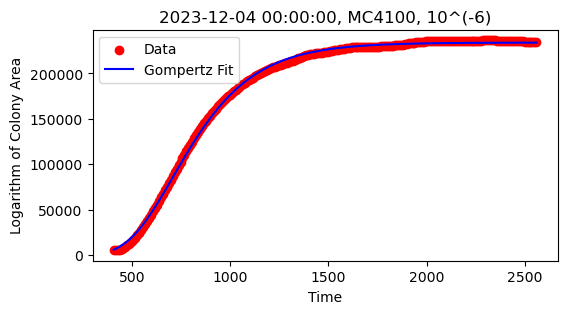

Fitted parameters [A, mu_m, lambda]: [234099.47613835    374.46317432    480.22818716], i: 63


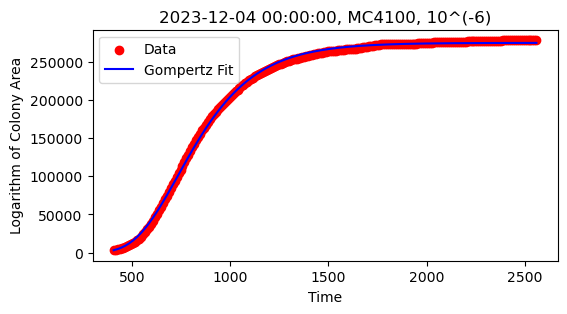

Fitted parameters [A, mu_m, lambda]: [274691.68168829    462.61158121    517.05143607], i: 64


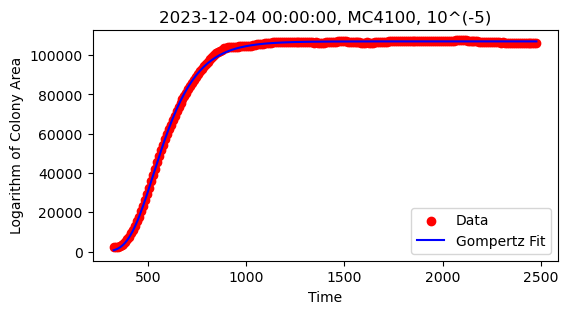

Fitted parameters [A, mu_m, lambda]: [106990.96855914    315.03894617    403.50158631], i: 65


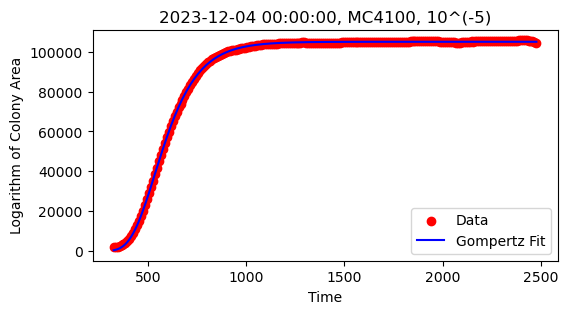

Fitted parameters [A, mu_m, lambda]: [104944.13054718    315.6344647     413.42007534], i: 66


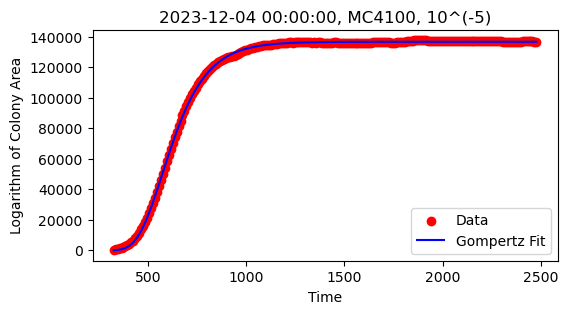

Fitted parameters [A, mu_m, lambda]: [136742.7638646     399.85968567    448.0181967 ], i: 67


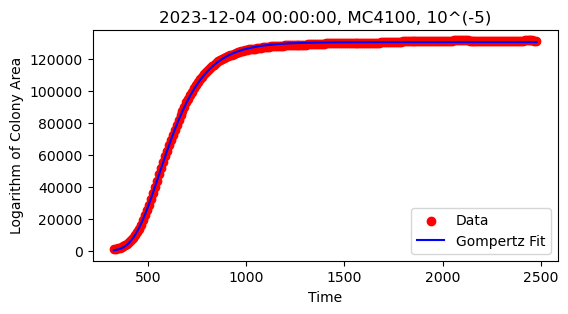

Fitted parameters [A, mu_m, lambda]: [130448.20280584    370.67544035    428.23340691], i: 68


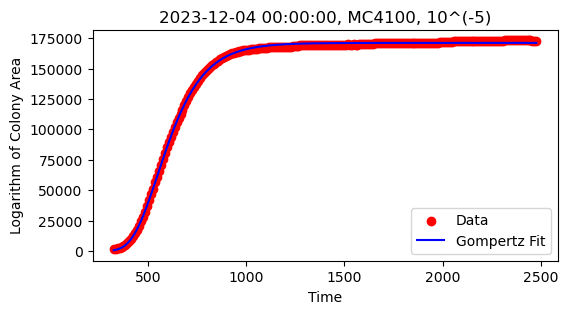

Fitted parameters [A, mu_m, lambda]: [171065.22158653    486.62622165    421.03602154], i: 69


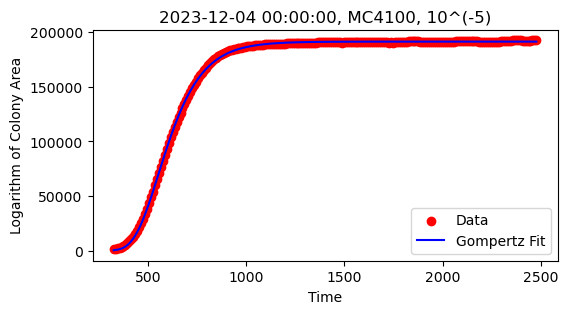

Fitted parameters [A, mu_m, lambda]: [191453.77541154    573.29768764    431.74146601], i: 70


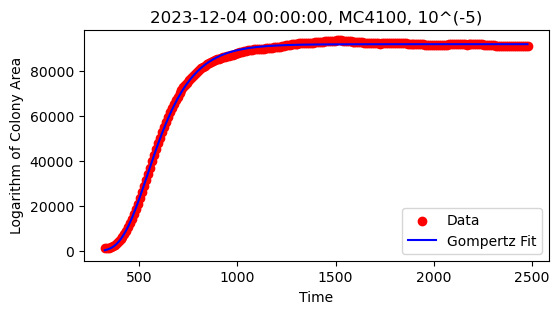

Fitted parameters [A, mu_m, lambda]: [91860.56084375   260.37030179   412.65713056], i: 71


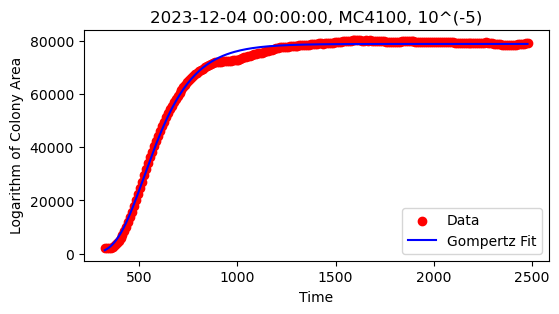

Fitted parameters [A, mu_m, lambda]: [78851.97468256   205.64422239   385.19475826], i: 72


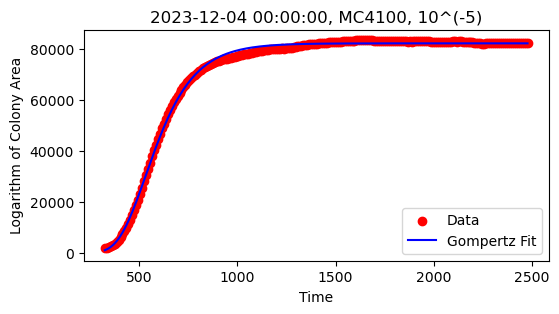

Fitted parameters [A, mu_m, lambda]: [82059.473953     218.20412613   395.71384847], i: 73


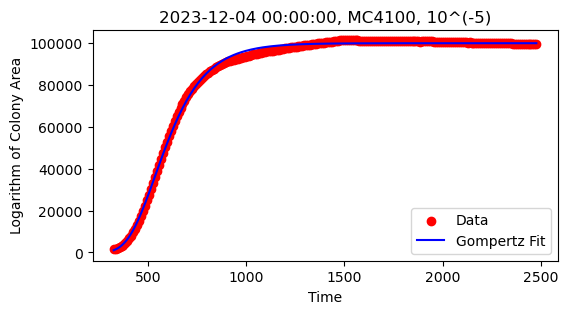

Fitted parameters [A, mu_m, lambda]: [99760.32083437   262.12767969   397.70548341], i: 74


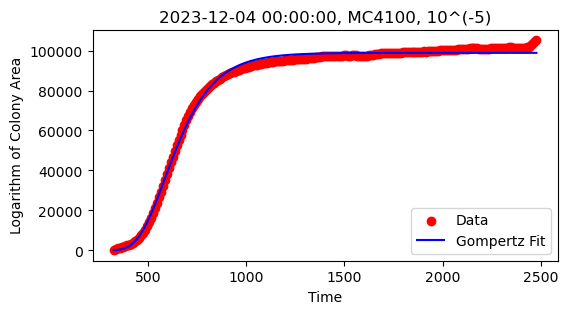

Fitted parameters [A, mu_m, lambda]: [98831.84132389   264.69133763   450.51459362], i: 75


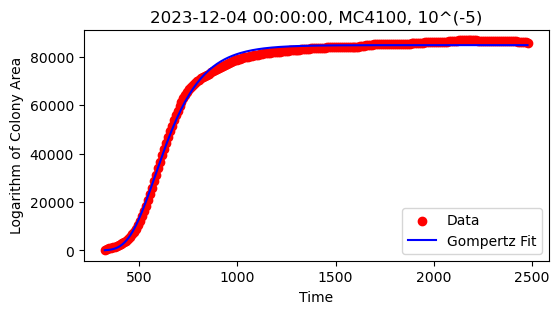

Fitted parameters [A, mu_m, lambda]: [84910.20133546   234.05403441   450.00225504], i: 76


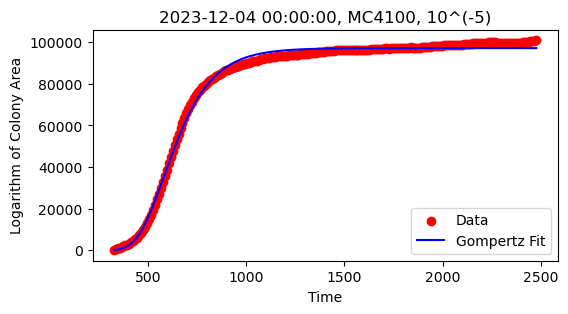

Fitted parameters [A, mu_m, lambda]: [97225.85420442   262.47766968   446.45940614], i: 77


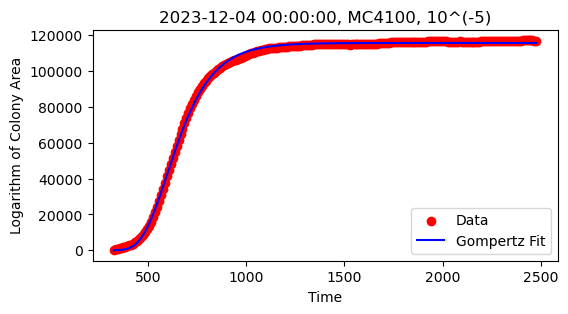

Fitted parameters [A, mu_m, lambda]: [115722.10082872    331.95299756    470.11992901], i: 78


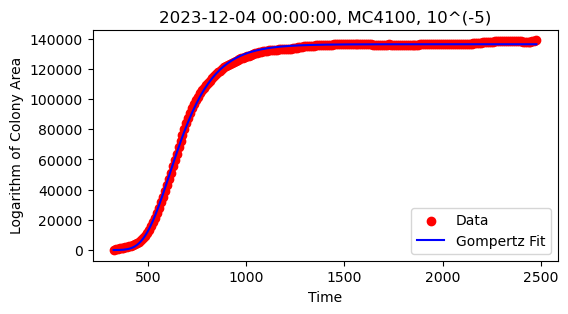

Fitted parameters [A, mu_m, lambda]: [136305.32268728    395.97346285    483.53686046], i: 79


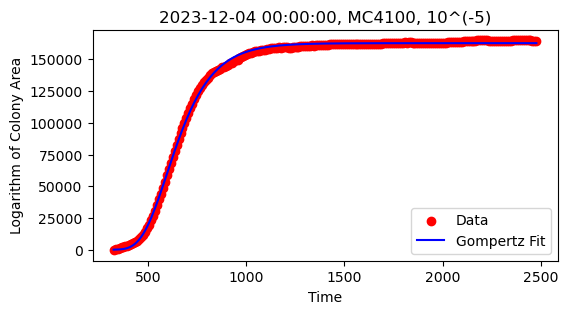

Fitted parameters [A, mu_m, lambda]: [162788.68897313    466.83132165    468.73529123], i: 80


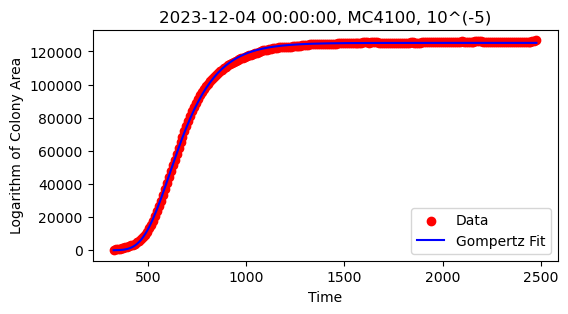

Fitted parameters [A, mu_m, lambda]: [125138.62997004    347.14771405    477.61111623], i: 81


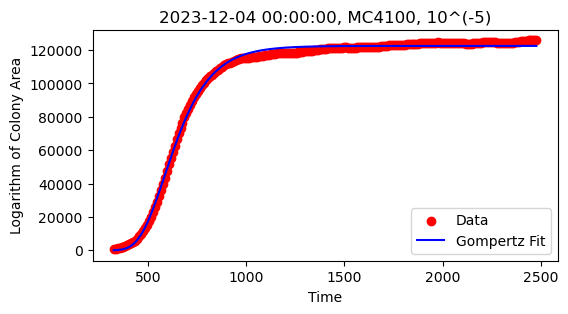

Fitted parameters [A, mu_m, lambda]: [122463.58239574    350.53447542    457.91298051], i: 82


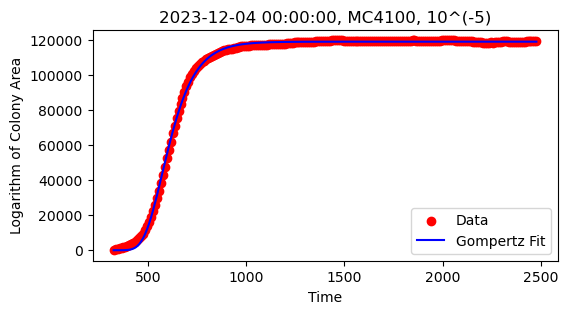

Fitted parameters [A, mu_m, lambda]: [118865.86709353    470.52140224    480.15943997], i: 83


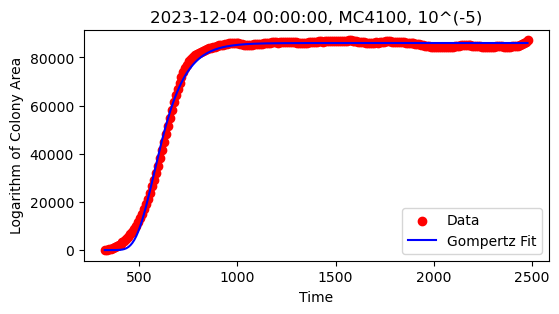

Fitted parameters [A, mu_m, lambda]: [86018.88839279   350.25393039   485.37500061], i: 84


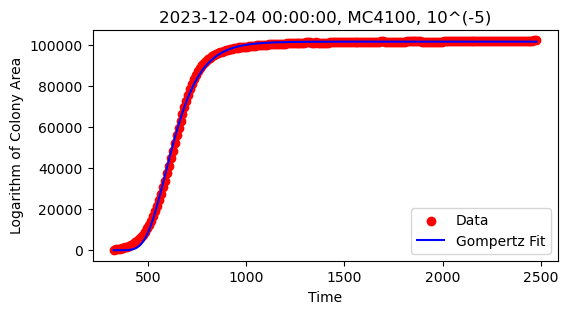

Fitted parameters [A, mu_m, lambda]: [101500.22746625    379.85368204    490.98924549], i: 85


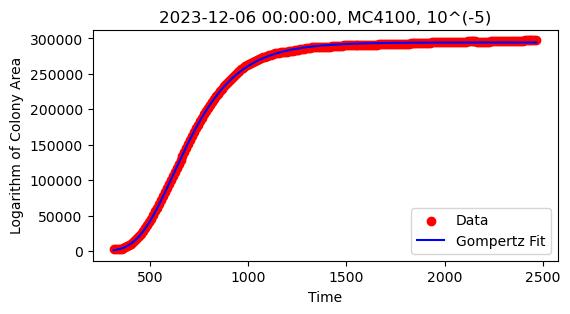

Fitted parameters [A, mu_m, lambda]: [294256.79777747    603.41783463    440.02857307], i: 86


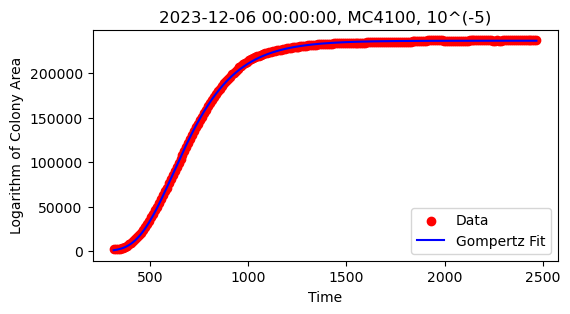

Fitted parameters [A, mu_m, lambda]: [236321.75716678    492.00000757    441.32692678], i: 87


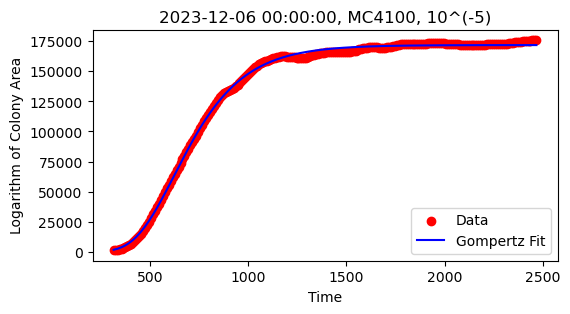

Fitted parameters [A, mu_m, lambda]: [171903.27130749    318.67944898    424.91502516], i: 88


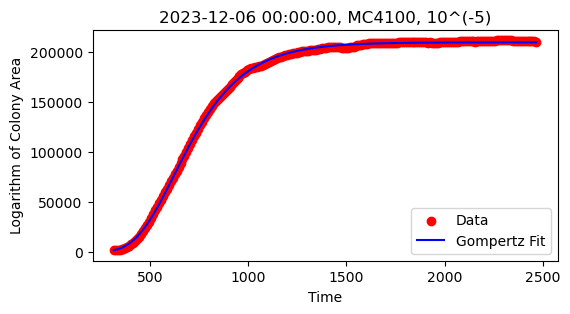

Fitted parameters [A, mu_m, lambda]: [209588.54983596    391.86830326    427.39873356], i: 89


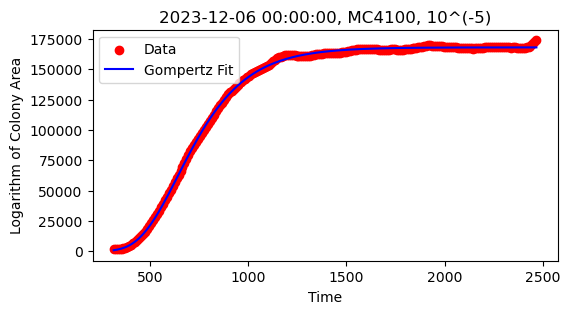

Fitted parameters [A, mu_m, lambda]: [168033.57091794    318.2862825     447.60326853], i: 90


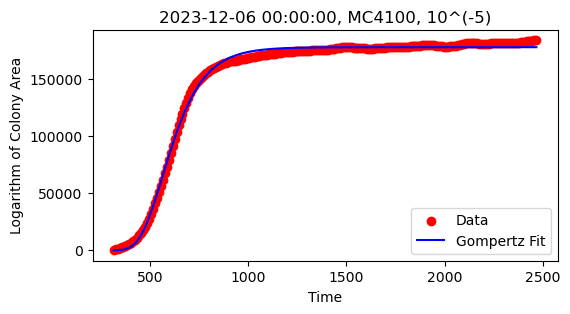

Fitted parameters [A, mu_m, lambda]: [177638.23835522    563.06467391    449.75337277], i: 91


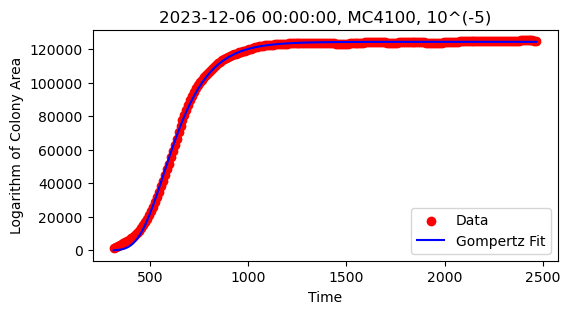

Fitted parameters [A, mu_m, lambda]: [124389.24346159    358.30758033    443.2657183 ], i: 92


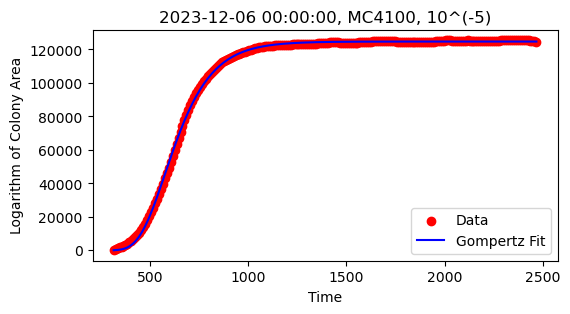

Fitted parameters [A, mu_m, lambda]: [124711.9920827     346.04790183    445.20678213], i: 93


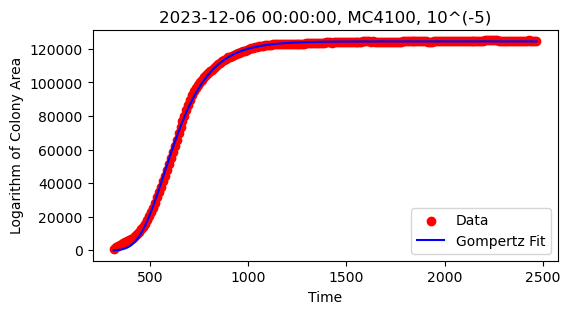

Fitted parameters [A, mu_m, lambda]: [124437.12000198    357.25505927    444.724118  ], i: 94


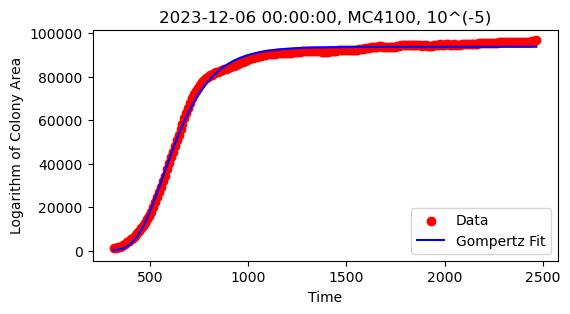

Fitted parameters [A, mu_m, lambda]: [93792.33507826   254.70282264   432.86963276], i: 95


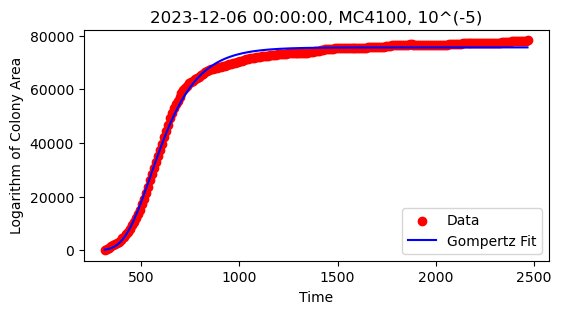

Fitted parameters [A, mu_m, lambda]: [75570.44831316   210.09149912   416.80285406], i: 96


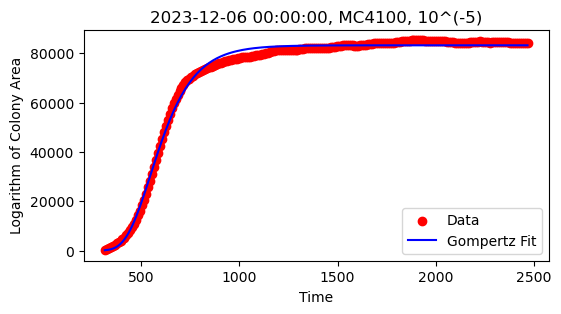

Fitted parameters [A, mu_m, lambda]: [83191.40461757   247.1671042    424.4262572 ], i: 97


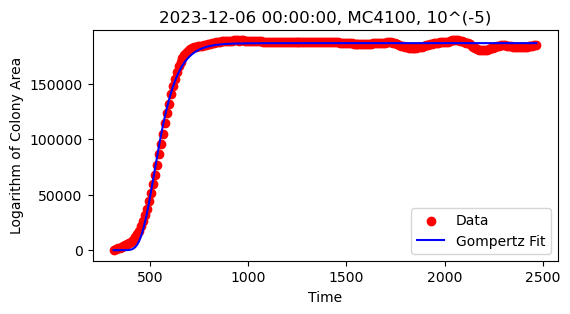

Fitted parameters [A, mu_m, lambda]: [186349.44854432   1029.71636937    454.91108456], i: 98


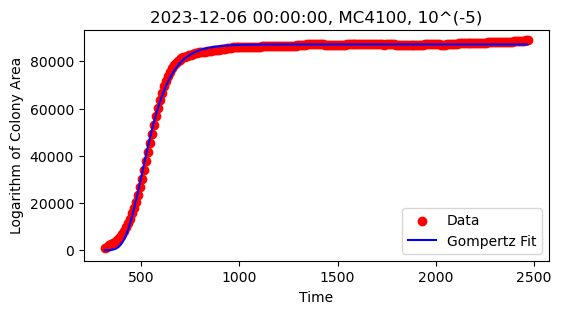

Fitted parameters [A, mu_m, lambda]: [87158.18642033   386.24342404   420.74504243], i: 99


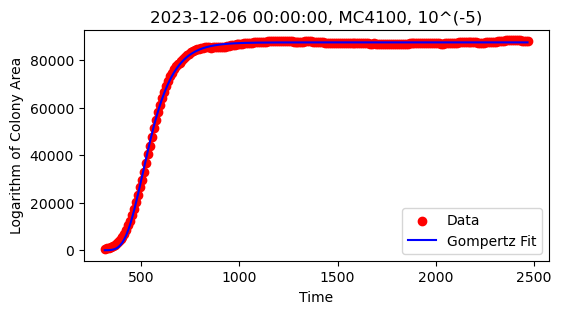

Fitted parameters [A, mu_m, lambda]: [87418.2861379    372.91696987   422.09087805], i: 100


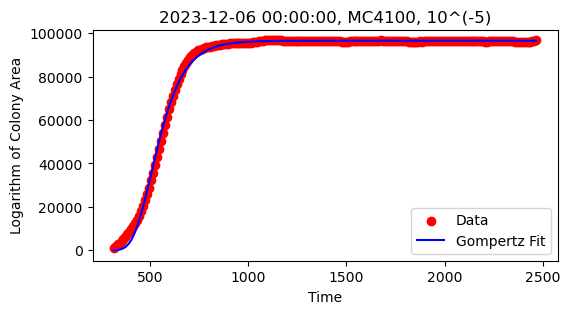

Fitted parameters [A, mu_m, lambda]: [96551.47567456   384.07613892   414.85266027], i: 101


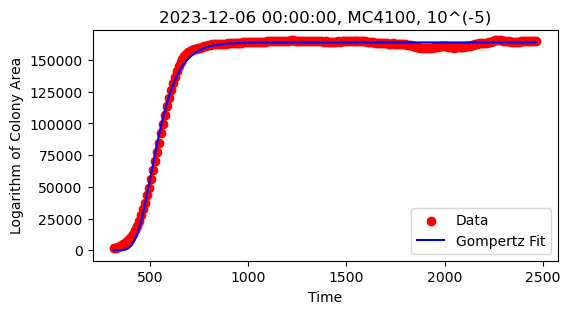

Fitted parameters [A, mu_m, lambda]: [163971.29012238    798.56153239    430.97101139], i: 102


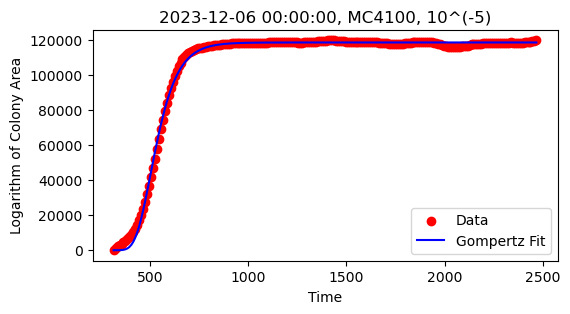

Fitted parameters [A, mu_m, lambda]: [118540.86164643    575.27650184    428.17974428], i: 103


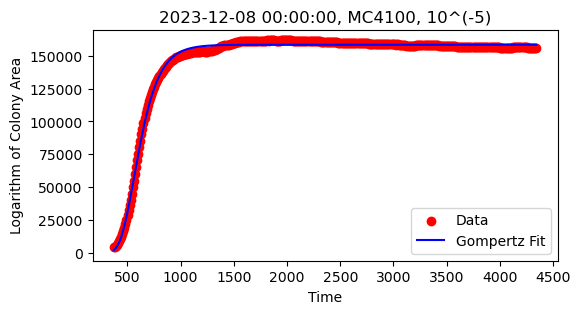

Fitted parameters [A, mu_m, lambda]: [158491.37496594    451.10061798    435.9160657 ], i: 104


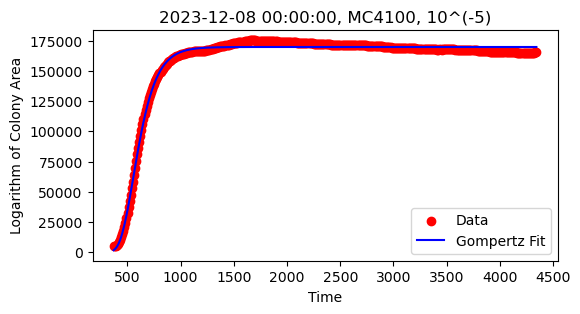

Fitted parameters [A, mu_m, lambda]: [169793.45911287    518.60745125    437.06496421], i: 105


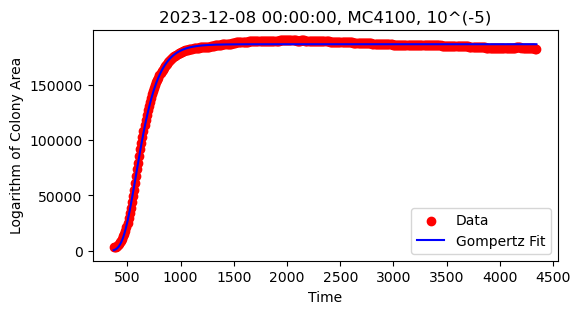

Fitted parameters [A, mu_m, lambda]: [186430.31042723    567.71736056    461.28710066], i: 106


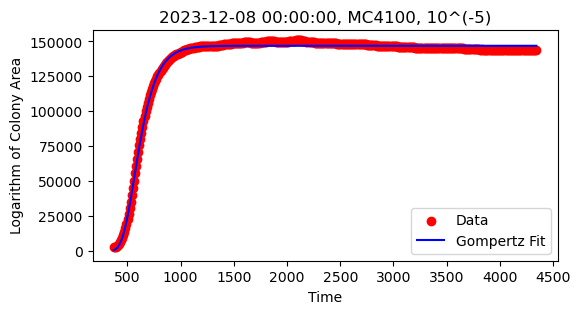

Fitted parameters [A, mu_m, lambda]: [146877.84776806    470.53245251    453.26268241], i: 107


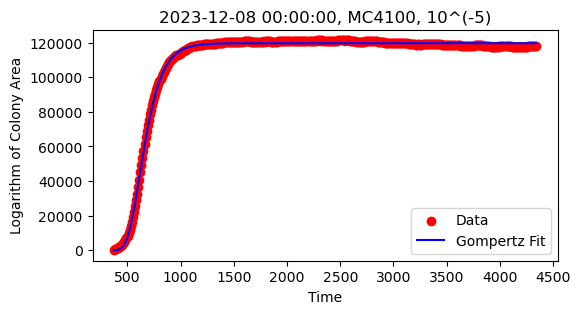

Fitted parameters [A, mu_m, lambda]: [119672.33653266    383.01922899    503.07903103], i: 108


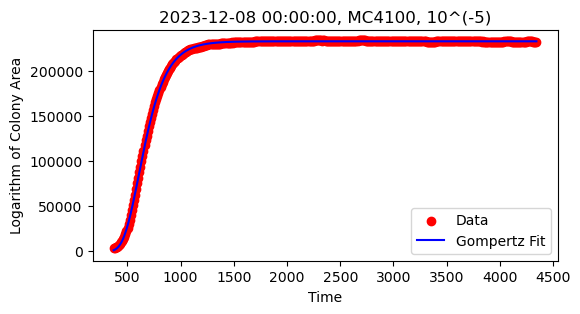

Fitted parameters [A, mu_m, lambda]: [232758.78250027    593.95273093    465.3327639 ], i: 109


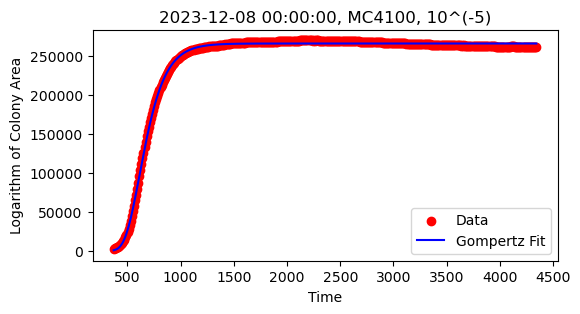

Fitted parameters [A, mu_m, lambda]: [266093.50476705    721.95929852    480.26140374], i: 110


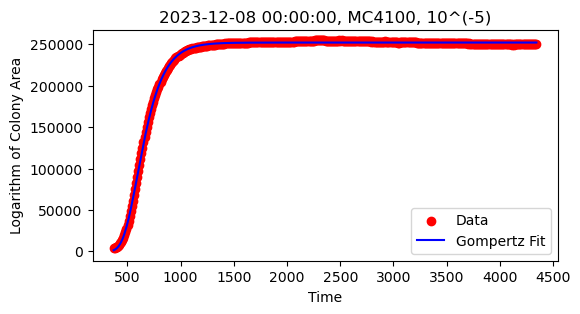

Fitted parameters [A, mu_m, lambda]: [252056.3319314     680.99744729    460.04521501], i: 111


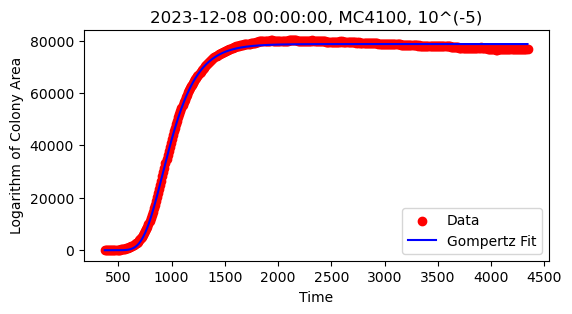

Fitted parameters [A, mu_m, lambda]: [78651.996624     160.33818766   733.88616747], i: 112


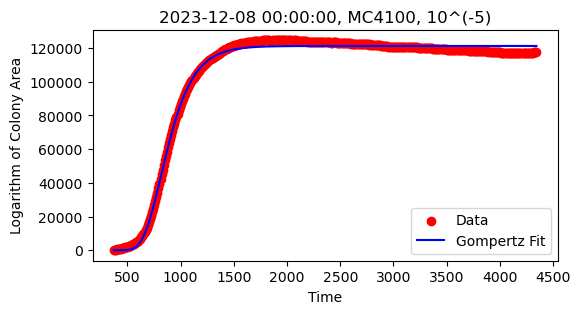

Fitted parameters [A, mu_m, lambda]: [121235.60296127    265.28993079    650.18860927], i: 113


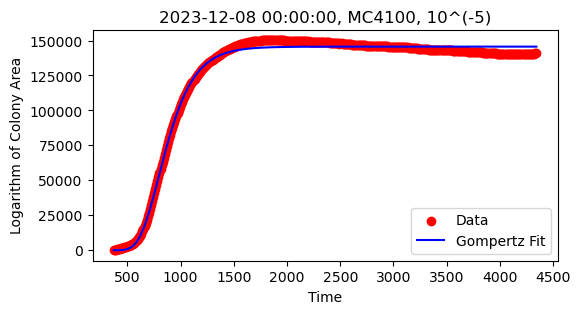

Fitted parameters [A, mu_m, lambda]: [145649.28908088    294.37741236    616.47420731], i: 114


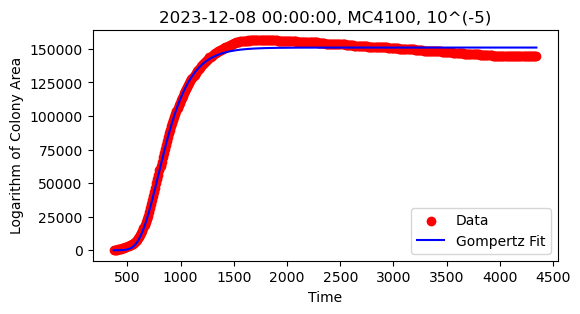

Fitted parameters [A, mu_m, lambda]: [150959.1756526     328.0804524     620.56048355], i: 115


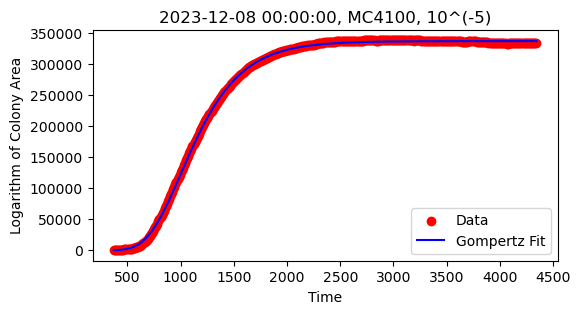

Fitted parameters [A, mu_m, lambda]: [336187.04169301    392.33331328    688.89403076], i: 116


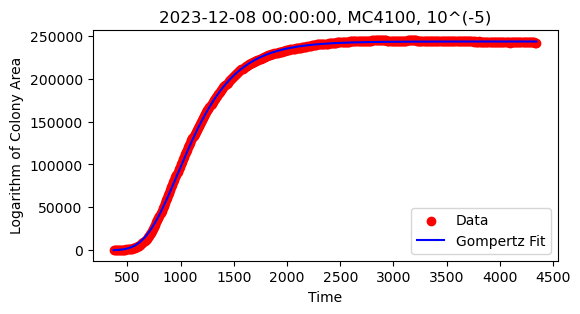

Fitted parameters [A, mu_m, lambda]: [243210.79137935    294.48177249    670.84340569], i: 117


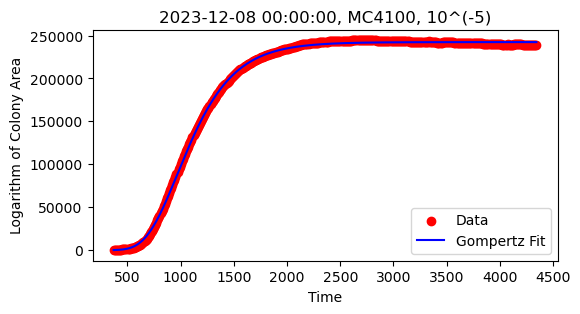

Fitted parameters [A, mu_m, lambda]: [242333.37731828    302.33436283    677.52828319], i: 118


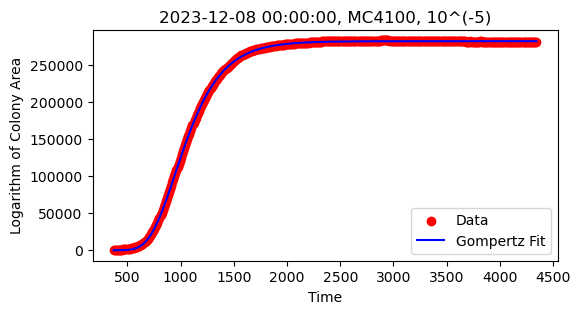

Fitted parameters [A, mu_m, lambda]: [281678.96219884    430.00226643    710.30640913], i: 119


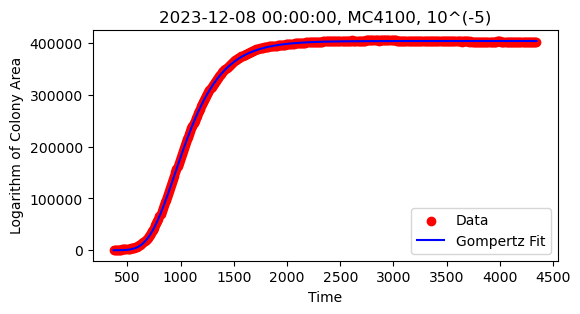

Fitted parameters [A, mu_m, lambda]: [403796.17851816    605.07464482    703.26611216], i: 120


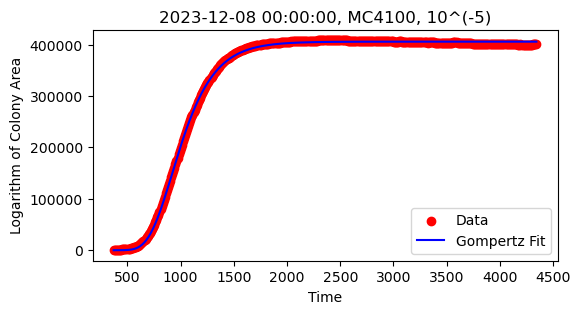

Fitted parameters [A, mu_m, lambda]: [405637.65489885    679.64865905    701.93484487], i: 121


ValueError: operands could not be broadcast together with shapes (406,) (216,) 

In [56]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

for i in df.index.values:
    # Fit the model
    incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
    incub_time_n = incub_time_s.seconds / 60
    area = extract_array(df.loc[i,'area_dyn'])
    #time_points = np.arange(1, df.loc[i, 'exp length']+1)*10 + incub_time_n
    time_points = np.arange(0, df.loc[i, 'exp length'])*10 + incub_time_n
    area_end = int(df.loc[i, 'area'])
    
    p0=[area_end, 100, incub_time_n]
    
    params, cov = curve_fit(gompertz, time_points, area, p0)
    # Plotting the data and the model to see the fit
    plt.figure(figsize=(6, 3))
    plt.scatter(time_points, area, color='red', label='Data')
    plt.plot(time_points, gompertz(time_points, *params), label='Gompertz Fit', color='blue')
    plt.title(f"{df.loc[i,'Date']}, {df.loc[i,'Strain']}, {df.loc[i,'Dilution']}")
    plt.xlabel('Time')
    plt.ylabel('Logarithm of Colony Area')
    plt.legend()
    plt.show()
    pars_dict = {'A': round(params[0],2), 'mu_m': round(params[1],2), 'lambda': round(params[2],2)}
    df.at[i, 'gomp_params'] = json.dumps(pars_dict)
    # Print the fitted parameters
    print(f"Fitted parameters [A, mu_m, lambda]: {params}, i: {i}")
df.to_excel('out.xlsx')

In [213]:
params

array([97920.94890256,   223.07422372,   507.01722267])

In [152]:
import json

### Computing t_m

In [149]:
def tm(A, mu, lambda_):
    return A/(mu * np.e) + lambda_

In [155]:
for i in df.index.values:
    pars = json.loads(df.loc[i,'gomp_params'])
    df.loc[i, 't_m'] = tm(pars['A'], pars['mu_m'], pars['lambda'])
df.to_excel('out.xlsx')

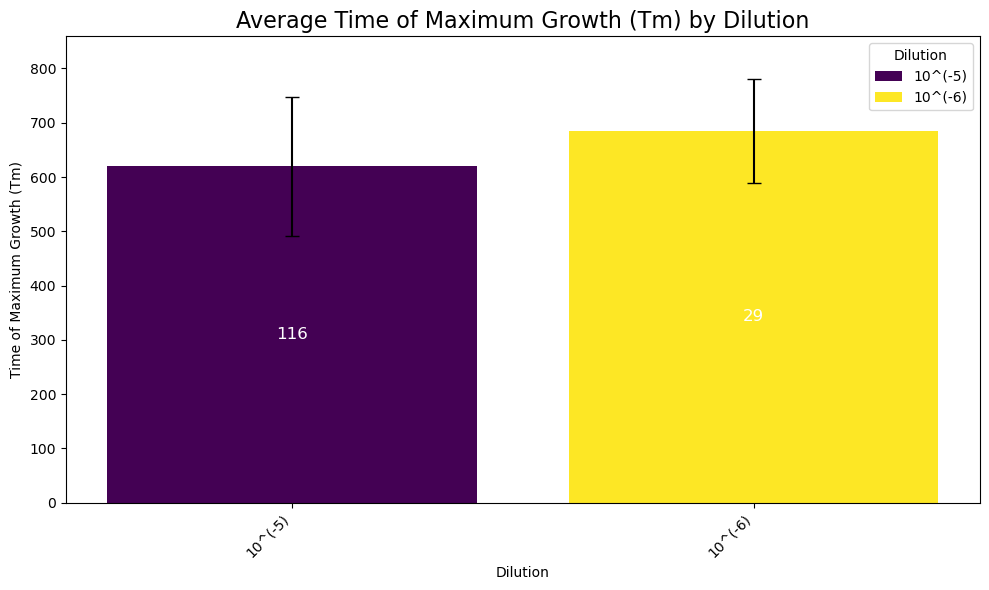

In [158]:
# Group the data by 'Dilution' and calculate mean, standard deviation, and count for 't_m'
plot_data = df.groupby('Dilution').agg({
    't_m': ['mean', 'std'],
    'Colonies': 'size'  # This counts the number of rows (colonies) per group
}).reset_index()

# Prepare the data for plotting
plot_data.columns = ['Dilution', 'Tm Mean', 'Tm Std', 'Colonies Count']

# Find the global maximum for the y-axis to ensure proper scale
max_tm = plot_data['Tm Mean'] + plot_data['Tm Std']
global_max = max_tm.max()

# Create a single plot for all dilutions
fig, ax = plt.subplots(figsize=(10, 6))

# Generate a color range
tm_colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))

# Plot each dilution
for idx, row in plot_data.iterrows():
    ax.bar(idx, row['Tm Mean'], yerr=row['Tm Std'], capsize=5, color=tm_colors[idx], label=row['Dilution'])
    # Annotate the number of colonies inside the bar
    ax.text(idx, row['Tm Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)

ax.set_title('Average Time of Maximum Growth (Tm) by Dilution', fontsize=16)
ax.set_xlabel('Dilution')
ax.set_ylabel('Time of Maximum Growth (Tm)')
ax.set_xticks(np.arange(len(plot_data)))
ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
ax.legend(title="Dilution")

plt.tight_layout()
plt.show()

# Save the figure to a file
fig.savefig('Tm_by_Dilution_Bar.png', dpi=300)


In [5]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

From here I can use the parameters to fin the maximum growth rate, max av growth rate, etc

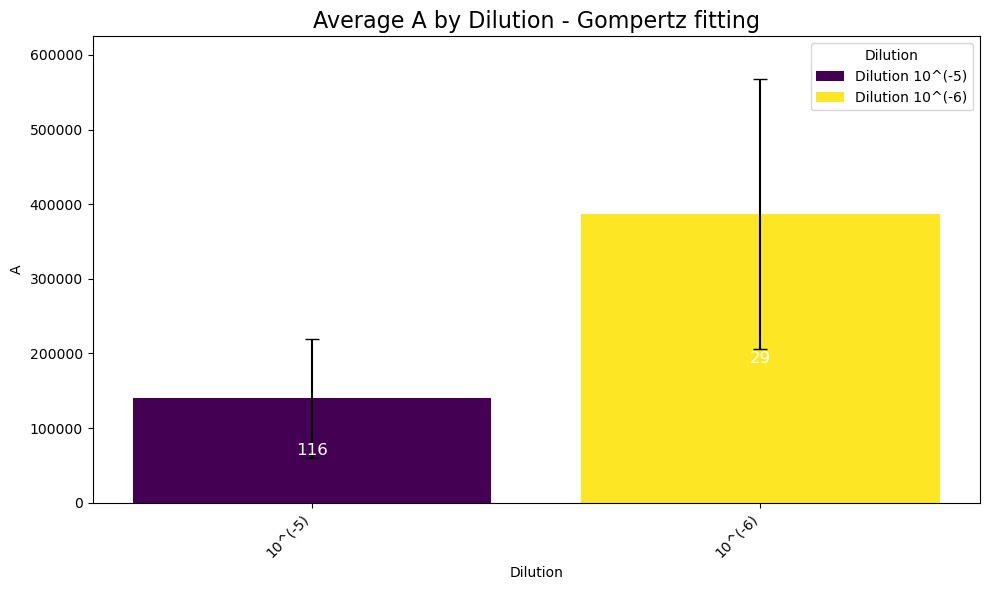

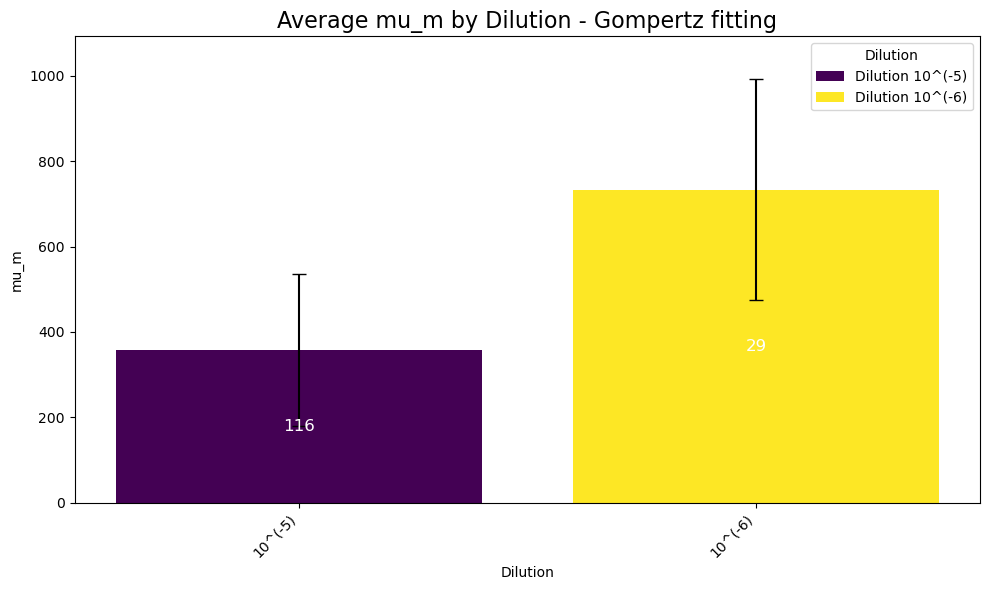

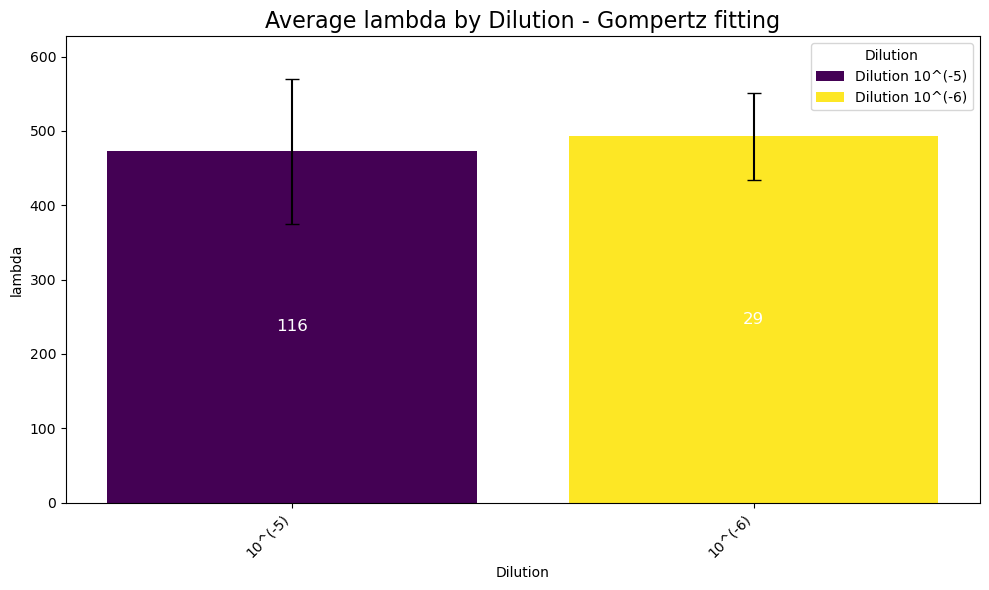

In [138]:
# Assuming 'gomp_params' is stored in JSON format with keys like 'A', 'mu_m', 'lambda'
# Convert JSON formatted string in 'gomp_params' to dictionary and extract 'lambda'
params = ['A', 'mu_m', 'lambda']
for param in params:
    df[param] = df['gomp_params'].apply(lambda x: json.loads(x)[param])
    
    # Group the data by 'Dilution' and calculate mean, standard deviation for 'lambda'
    plot_data = df.groupby('Dilution').agg({
        param: ['mean', 'std', 'size']  # 'size' to count entries, replace 'std' with 'sem' if std is not reliable
    }).reset_index()
    
    # Prepare the data for plotting
    plot_data.columns = ['Dilution', f'{param} Mean', f'{param} Std', 'Colonies Count']
    
    # Find the global maximum for the y-axis to ensure proper scale
    maxx = plot_data[f'{param} Mean'] + plot_data[f'{param} Std']
    global_max = maxx.max()
    
    # Create a single plot for all dilutions
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Generate a color range
    colors = plt.cm.viridis(np.linspace(0, 1, len(plot_data)))
    
    # Plot each dilution
    for idx, row in plot_data.iterrows():
        ax.bar(idx, row[f'{param} Mean'], yerr=row[f'{param} Std'], capsize=5, color=colors[idx], label=f"Dilution {row['Dilution']}")
        # Annotate the number of colonies inside the bar
        ax.text(idx, row[f'{param} Mean']/2, str(row['Colonies Count']), ha='center', va='center', color='white', fontsize=12)
    
    ax.set_title(f'Average {param} by Dilution - Gompertz fitting', fontsize=16)
    ax.set_xlabel('Dilution')
    ax.set_ylabel(param)
    ax.set_xticks(np.arange(len(plot_data)))
    ax.set_xticklabels(plot_data['Dilution'], rotation=45, ha="right")
    ax.set_ylim(0, global_max * 1.1)  # Set consistent y-axis limits
    ax.legend(title="Dilution")
    
    plt.tight_layout()
    plt.show()

# Save the figure
    fig.savefig(f'{param}_Dil_Bar.png', dpi=300)  # Adjust path as needed


In [167]:
df_out = pd.read_excel('out.xlsx')
df = df_out.copy()

In [11]:
exp = df[(df.Date == '2023-11-28') & (df.Machine == 'Ti scope') & (df.Position == 2)]
exp

Unnamed: 0.1  Unnamed: 0       Date   Machine  Position  Strain   DNA  \
20            20          20 2023-11-28  Ti scope         2  MC4100  pAAA   

   Chemical  Pad Dilution  ... radj wedge_adj      radius           area  \
20        -    1  10^(-6)  ...   20        30  430.276588  581210.587804   

    max_av_gr                                            rad_dyn  \
20   0.153556  [ 46.37693285  47.56288849  52.055471    55.18...   

                                             area_dyn  \
20  [  6933.62450593   7353.68887634   8184.171149...   

                                            av_gr_dyn  \
20  [ 7.60629732e-02  1.01152068e-01  1.20718178e-...   

                                          gomp_params         t_m  
20  {"A": 579569.28, "mu_m": 941.61, "lambda": 503...  729.983049  

[1 rows x 27 columns]

In [15]:
i = exp.index[0]

In [16]:
t_m = exp['t_m'][i]
A = json.loads(exp['gomp_params'][i])["A"]
mu_m = json.loads(exp['gomp_params'][i])["mu_m"]
lambda_ = json.loads(exp['gomp_params'][i])["lambda"]

In [17]:
lambda_

503.55

In [18]:
tdoub = np.log(2) / (mu_m * np.e)
tdoub*10

0.0027080701929031504

In [19]:
mu_m

941.61

In [20]:
incub_time_s = datetime.strptime(df.loc[i,'t_im'], '%H:%M:%S') - datetime.strptime(df.loc[i,'t_incub'], '%H:%M:%S')
incub_time_n = incub_time_s.seconds / 60
incub_time_n

374.0

In [26]:
time_points = np.arange(0, df.loc[i, 'exp length']*10 + incub_time_n) 
time_points

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.531e+03, 2.532e+03,
       2.533e+03])

In [27]:
time_points

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.531e+03, 2.532e+03,
       2.533e+03])

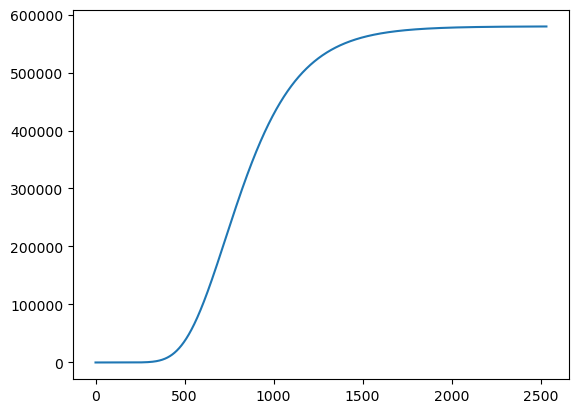

In [30]:
plt.plot(time_points, gompertz(time_points,A,mu_m, lambda_))